## Exploring the relationship between performance metrics and cost saving potential
This notebook follows the research paper registration by S. Herbold: https://arxiv.org/abs/2104.00566

### _Content_
- #### Imports & Utils
- #### #1 Descriptive Statistics and Data Visualization
    - dataset completeness check
    - descriptive statistics
    - distribution of independent and confounding variables (+ log-distribution)
    - distribution of cost saving bounds difference ('diff') (+ log-distribution)
    - scatter plots between independent and confounding variables and lg(diff)
    - overall correlation matrix
    - correlation groups
    - distribution of dependent variable: cost saving potential
    - influence of preprocessing
    
 - #### #2 Evaluation Models    
    ##### logit
    - regularization parameter optimization
    - run logit model
    - plot coefficients

    ##### decision tree
    - run decision tree model
    - tree visualization
    - feature importance

    ##### random forest
    - hyperparameter tuning with differential evolution
    - run random forest model
    - average feature importance
    
 - #### #3 Confirmatory Analysis
 - #### #4 Generalization

### Imports

In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

from scipy.optimize import differential_evolution
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

### Settings

In [2]:
pd.set_option('display.max_columns', 40)

CORRELATION_THRESHOLD = 0.8
SPLIT_TEST_RATIO = 0.3
FIRST_NUM_FEATURE_IDX = 2

DATA_PATH = "data"
FIGURE_PATH = "plots"
LOGIT_OPTIM_DIR = os.path.join(FIGURE_PATH, "logit_optim")
LOGIT_COEF_DIR = os.path.join(FIGURE_PATH, "logit_coef")
CONFUSION_MAT_DIR = os.path.join(FIGURE_PATH, "cm")
CORRELATION_DIR = os.path.join(FIGURE_PATH, "corr")
GENERALIZATION_DIR = os.path.join(FIGURE_PATH, "generalization")
if not os.path.exists(FIGURE_PATH):
    os.makedirs(FIGURE_PATH)
if not os.path.exists(LOGIT_OPTIM_DIR):
    os.makedirs(LOGIT_OPTIM_DIR)
if not os.path.exists(LOGIT_COEF_DIR):
    os.makedirs(LOGIT_COEF_DIR)
if not os.path.exists(CONFUSION_MAT_DIR):
    os.makedirs(CONFUSION_MAT_DIR)
if not os.path.exists(CORRELATION_DIR):
    os.makedirs(CORRELATION_DIR)
if not os.path.exists(GENERALIZATION_DIR):
    os.makedirs(GENERALIZATION_DIR)

### Utilities

In [3]:
def dataset_overview(df):
    """Gives an overview of the dataframe to check for its completeness."""
    num_releases = df["release"].nunique()
    instances_per_release = df["num_test"].groupby(df["release"]).count().unique().tolist()
    print(f"Number of releases: {num_releases}")
    print(f"Instances per release: {instances_per_release}")
    print(f"Total number of instances: {df.shape[0]}")
    print(f"Rows containing NaN values: {df[df.drop('diff', axis=1).isna().any(axis=1)].shape[0]}")

    
def dataset_descriptive_stats(df):
    """Returns a dataframe containing descriptive statistics for every feature."""
    desc_stats = pd.DataFrame(columns=df.columns)
    desc_stats = desc_stats.append((df.mean(axis=0).rename("mean")))
    desc_stats = desc_stats.append(df.std(axis=0).rename("std"))
    desc_stats = desc_stats.append(df.min(axis=0, numeric_only=True).rename("min"))
    desc_stats = desc_stats.append(df.max(axis=0, numeric_only=True).rename("max"))
    desc_stats = desc_stats.append(df.median(axis=0).rename("median"))
    desc_stats = desc_stats.append(df.quantile(0.25).rename("25q"))
    desc_stats = desc_stats.append(df.quantile(0.75).rename("75q"))
    return desc_stats


def detect_correlation_groups(overall_spearman_corr_map, df_numeric, save_dir, threshold):
    """Devides the features into groups where every member of the group has a spearman rank correlation higher than a threshold value 
    with at least one other member of the group."""
    
    class CorrGroup:
        """Keeps elements which belong to the same correlation group."""

        def __init__(self, elem_list):
            self.elements = elem_list

        def check_and_add(self, a, b):
            """Checks if at least one of the two elements is already part of the correlation group 
            and adds the missing element if only one is included.

            Returns:
                True if elements are part of the group and False otherwise.
            """
            contains_a = False
            contains_b = False
            for element in self.elements:
                if element == a:
                    contains_a = True
                if element == b:
                    contains_b = True
            if contains_a == True and contains_b == True:
                return True
            elif contains_a == True and contains_b == False:
                self.elements.append(b)
                return True
            elif contains_a == False and contains_b == True:
                self.elements.append(a)
                return True
            else:
                return False

    corr_matrix = overall_spearman_corr_map
    temp_groups = []
    for i, corr_row in enumerate(corr_matrix):
        for j, c in enumerate(corr_row):
            if i != j:
                if abs(c) > threshold:
                    group_found = False
                    for group in temp_groups:
                        group_found = group.check_and_add(a=i,b=j)
                    if not group_found:
                        temp_groups.append(CorrGroup([i,j]))
    corr_groups = []                    
    for group in temp_groups:
        group_handled = False
        for cg in corr_groups:
            if any(x in group.elements for x in cg):
                cg = np.unique(cg+group.elements)
                group_handled = True
        if not group_handled:
            corr_groups.append(group.elements)
    counter = 0       
    for group in corr_groups:
        df_group = df_numeric.iloc[:,group]
        spearman_corr_map = spearmanr(a=df_group).correlation
        if df_group.shape[1] == 2:
            spearman_corr_map = [[1,spearman_corr_map],[spearman_corr_map,1]]
        plt.figure(figsize=(5,5))
        ax = sns.heatmap(spearman_corr_map, square=True, annot=True, xticklabels=df_group.columns, yticklabels=df_group.columns, cmap="vlag", vmin=-1, vmax=1)
        plt.savefig(os.path.join(save_dir, f"corr_group_{counter}.pdf"), bbox_inches='tight')
        plt.title(f"Correlation group {counter}")
        plt.show()
        counter += 1


def bar_plot_wrapper(data, x_labels, data_std=None, set_labels=None, filename=None, title="Logit model coefficients",
                     xlabel="feature", ylabel="coefficients", figsize=(8, 4), rotate_ticks=False):
    """Wrapper around pyplot's bar function in order to plot coefficent diagrams."""

    length = data.shape[0]
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.8 / data.shape[1]
    x = np.arange(length)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.4)

    for i in range(data.shape[1]):
        if data_std is None and set_labels is None:
            ax.bar(x + (i * width), data[:, i], width)
        elif set_labels is None:
            ax.bar(x + (i * width), data[:, i], width, yerr=data_std[:, i])
        elif data_std is None:
            ax.bar(x + (i * width), data[:, i], width, label=set_labels[i])
        else:
            ax.bar(x + (i * width), data[:, i], width, label=set_labels[i], yerr=data_std[:, i])

    ax.set_xticks(x + width * (data.shape[1] - 1) / 2)
    ax.set_xticklabels(x_labels)
    if rotate_ticks:
        plt.xticks(rotation=90)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if set_labels is not None:
        ax.legend()
    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.2)
    for j in range(1, data.shape[0]):
        plt.axvline(x=x[j] + width * (data.shape[1] - 1) / 2 - 0.5, color='black', linestyle='-', linewidth=0.4)
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, bbox_inches="tight")
    if title is not None:
        ax.set_title(title)
    fig.tight_layout()
    plt.show()

    
def confusion_matrix_eval(cm, class_labels):
    """Evaluates a confusion matrix and returns a dataframe with the statistics."""
    
    cm_df = pd.DataFrame(columns=class_labels)
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        temp[i] = row[i]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="correctly_predicted"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i+1 < cm.shape[0]:
            temp[i] = row[i+1]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="moderate_overprediction"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i+1 < cm.shape[0]:
            temp[i] = row[i+1:].sum()/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="overall_overprediction"))
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i > 0:
            temp[i] = row[i-1]/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="moderate_underprediction")) 
    
    temp = [None, None, None, None]
    for i, row in enumerate(cm):
        if i > 0:
            temp[i] = row[:i].sum()/row.sum()
    cm_df = cm_df.append(pd.Series(temp, index=classes, name="overall_underprediction"))
    return cm_df


# setup for metrics dataframe
metrics_names = ['name', 'training t.', 'prediction t.', 'recall', 'precision', 'accuracy', 'F1 measure', 'MCC']
metrics_df = pd.DataFrame(columns=metrics_names)

def performance_eval(y_model, ytest, class_labels, t=None, name="", df=metrics_df, save_dir=CONFUSION_MAT_DIR):
    """Calculates different metrics to evaluate a model's performance and plots the confusion matrix."""
    
    mcc = metrics.matthews_corrcoef(ytest, y_model)
    recall = metrics.recall_score(ytest, y_model, average='macro')
    precision = metrics.precision_score(ytest, y_model, average='macro')
    accuracy = metrics.accuracy_score(ytest, y_model)
    f1 = metrics.f1_score(ytest, y_model, average='macro')
    if t is None:
        t = [0, 0, 0]
    results = pd.Series([name, t[1]-t[0], t[2]-t[1], recall, precision, accuracy, f1, mcc], index = df.columns)
    print(results)
    cm = metrics.confusion_matrix(y_true=ytest, y_pred=y_model, labels=class_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = cm_norm.transpose()
    cm_norm = np.round(cm_norm, 3)
    ax = sns.heatmap(cm_norm, square=True, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
    plt.yticks(rotation=0)
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.savefig(os.path.join(save_dir, f"{name}_CM.pdf"), bbox_inches="tight")
    plt.show()
    cm_df = confusion_matrix_eval(cm, class_labels)
    print(cm_df)
    return results


def run_model(model, model_name, Xtrain, ytrain, Xtest, ytest, metrics, class_labels):
    """Runs and evaluates a sklearn machine learning model."""

    t0 = time.time()
    model.fit(X=Xtrain, y=ytrain)
    t1 = time.time()
    y_pred = model.predict(Xtest)
    t2 = time.time()
    metrics = metrics.append(performance_eval(y_model=y_pred, ytest=ytest, class_labels=class_labels, t=[t0,t1,t2], name=model_name), ignore_index=True)
    return model, metrics


def resort_coef(model_coef, model_classes, ordered_classes):
    """Returns the coefficient matrix resorted by the desired order of classes."""

    if len(model_classes) != len(ordered_classes):
        raise ValueError("The classes by the model and the ordered list of classes must have the same length.") 
    index_list = np.full(len(model_classes), -1)
    for i, ordered_c in enumerate(ordered_classes):
        for j, model_c in enumerate(model_classes):
            if ordered_c == model_c:
                index_list[i]=j
    _, unique_count = np.unique(index_list, return_counts=True)
    if unique_count.max() > 1 or -1 in index_list:
        raise ValueError("The two lists of classes do not consist of the same elements.")
    sorted_coef = model_coef[index_list]   
    return sorted_coef

### Read the data
The dataset is created by a bootstrap experiment in CrossPare and formatted by the notebook read_sql.ipynb



In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "metrics_vs_costsaving_bootstrap_experiment.csv"), index_col=0)
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (53000, 34)


# #1 Descriptive Statistics and Data Visualization
### Dataset completeness check
#### expected values:
- number of releases = 265 
- instances per release = 200 (2*100)
- total number of instances = 53000 (2*26500)
- no NaN values except the 'diff' column

In [5]:
dataset_overview(df)

Number of releases: 265
Instances per release: [200]
Total number of instances: 53000
Rows containing NaN values: 0


### Descriptive statistics

In [6]:
dataset_descriptive_stats(df)

C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


configuration  release    recall  precision       fpr    fscore  \
mean              NaN      NaN  0.171032   0.066191  0.022190 -0.034434   
std               NaN      NaN  0.216350   0.643319  0.032353  0.558016   
min               NaN      NaN  0.000000  -1.000000  0.000000 -1.000000   
max               NaN      NaN  1.000000   1.000000  0.404762  1.000000   
median            NaN      NaN  0.090909   0.250000  0.010989  0.142857   
25q               NaN      NaN  0.000000   0.000000  0.000000  0.000000   
75q               NaN      NaN  0.285714   0.500000  0.028571  0.333333   

          gscore   balance  accuracy     error  error_type1  error_type2  \
mean    0.239728  0.412477  0.928764  0.071236     0.326751     0.056615   
std     0.266212  0.150277  0.048461  0.048461     0.520102     0.041323   
min     0.000000  0.270018  0.600000  0.000000     0.000000     0.000000   
max     1.000000  1.000000  1.000000  0.400000    12.000000     0.476190   
median  0.166604  0.357168  0.940594  0.059406     0.190476     0.047120   
25q     0.000000  0.292893  0.905263  0.036232     0.000000     0.027778   
75q     0.441605  0.494521  0.963768  0.094737     0.428571     0.074074   

             mcc  consistency       auc  auc_alberg   auc_roi    necm10  \
mean   -0.273583     0.114417  0.790624    0.013403  0.575275  0.532306   
std     0.958115     0.222572  0.115931    0.018125  0.139337  0.346677   
min    -2.000000    -0.466667  0.055556    0.000000  0.012178  0.000000   
max     1.000000     1.000000  1.000000    0.185233  1.000000  3.181818   
median  0.129023     0.015152  0.807238    0.006870  0.572759  0.461538   
25q    -0.058436    -0.038462  0.725961    0.001053  0.493759  0.282759   
75q     0.342020     0.225238  0.870939    0.018157  0.653487  0.698630   

          necm25          cost     nofb20      nofc80  bias_train  \
mean    1.300757   3579.802868   2.763623   76.475075    0.065685   
std     0.855657   6453.838682   3.841023   72.797629    0.044151   
min     0.000000      0.000000   0.000000    1.000000    0.002347   
max     7.954545  56593.000000  35.000000  634.000000    0.333333   
median  1.126795    974.000000   2.000000   54.000000    0.054417   
25q     0.684685     82.000000   0.000000   26.000000    0.033482   
75q     1.709858   3037.000000   4.000000  101.000000    0.088435   

        bias_train_processed  bias_test  ratio_bias  ratio_bias_processed  \
mean                0.150173   0.065939    1.142955              0.726042   
std                 0.125453   0.045859    0.724122              0.686986   
min                 0.002347   0.002481    0.066808              0.023711   
max                 0.692641   0.382353   14.300000             14.300000   
median              0.108252   0.054348    1.004008              0.496633   
25q                 0.051220   0.032609    0.731631              0.258764   
75q                 0.218121   0.088608    1.347826              1.017794   

        prop1_defect  prop1_clean    num_train  num_train_processed  \
mean      152.347081    15.084337   506.490566           560.944302   
std       199.296946    12.954148   343.118544           383.734655   
min         5.600000     1.819095   100.000000           100.000000   
max      3756.000000    92.700000  1708.000000          1940.000000   
median     83.400000    10.806122   425.000000           462.000000   
25q        47.166667     6.866667   236.000000           250.000000   
75q       173.000000    16.954017   708.000000           766.000000   

          num_test         diff  potential  
mean    186.097717          NaN        NaN  
std     126.318760          NaN        NaN  
min      28.000000         -inf        NaN  
max     667.000000          inf        NaN  
median  153.000000   990.309524        NaN  
25q      86.000000          NaN        NaN  
75q     262.000000  2224.044118        NaN

### Distribution of independent and confounding variables

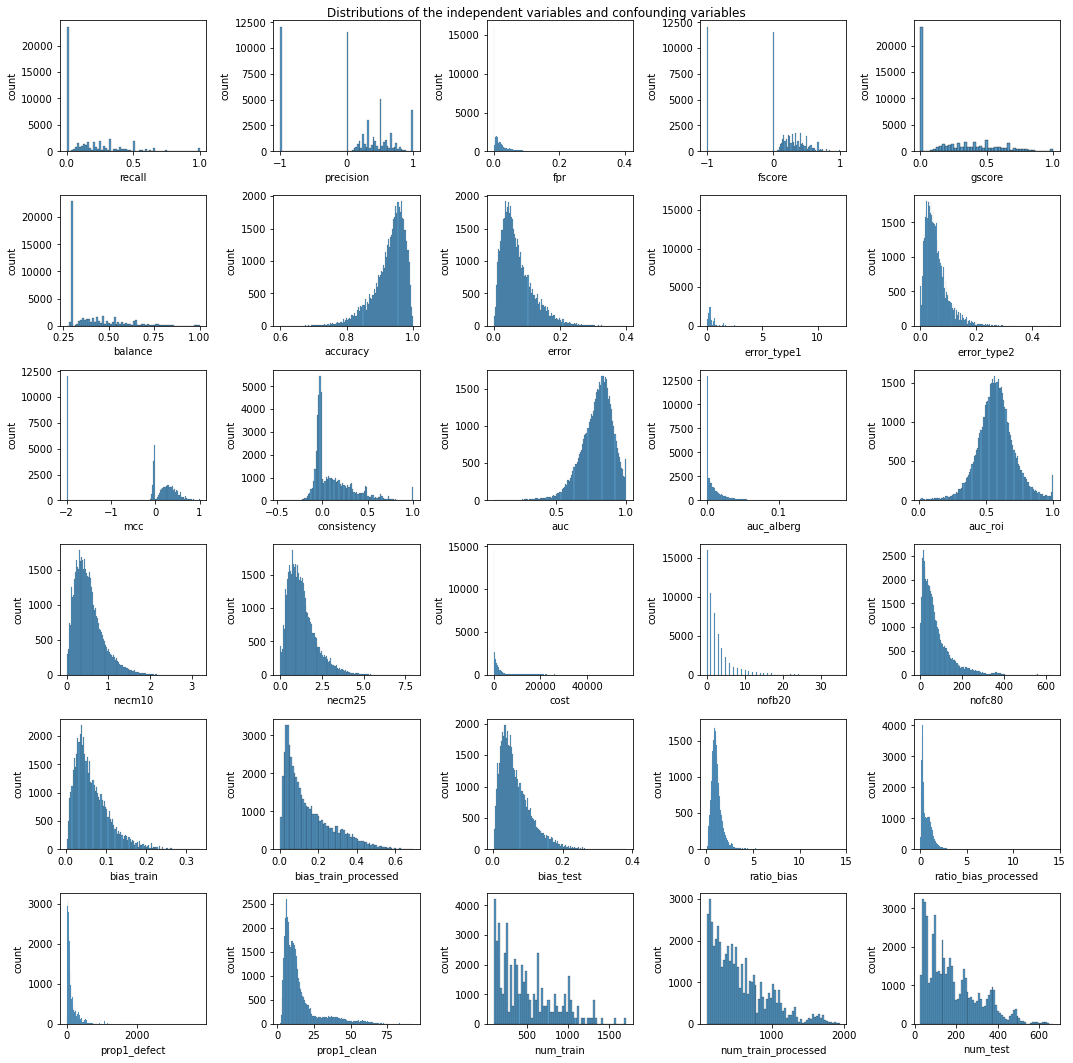

In [7]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))

feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(df, x=df.columns[feature_index], ax=col)
        col.set_ylabel("count")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, "dist_independent_and_confounding.pdf"), bbox_inches='tight')

fig.suptitle("Distributions of the independent variables and confounding variables")
plt.tight_layout()
plt.show()

### Log-distribution of independent and confounding variables

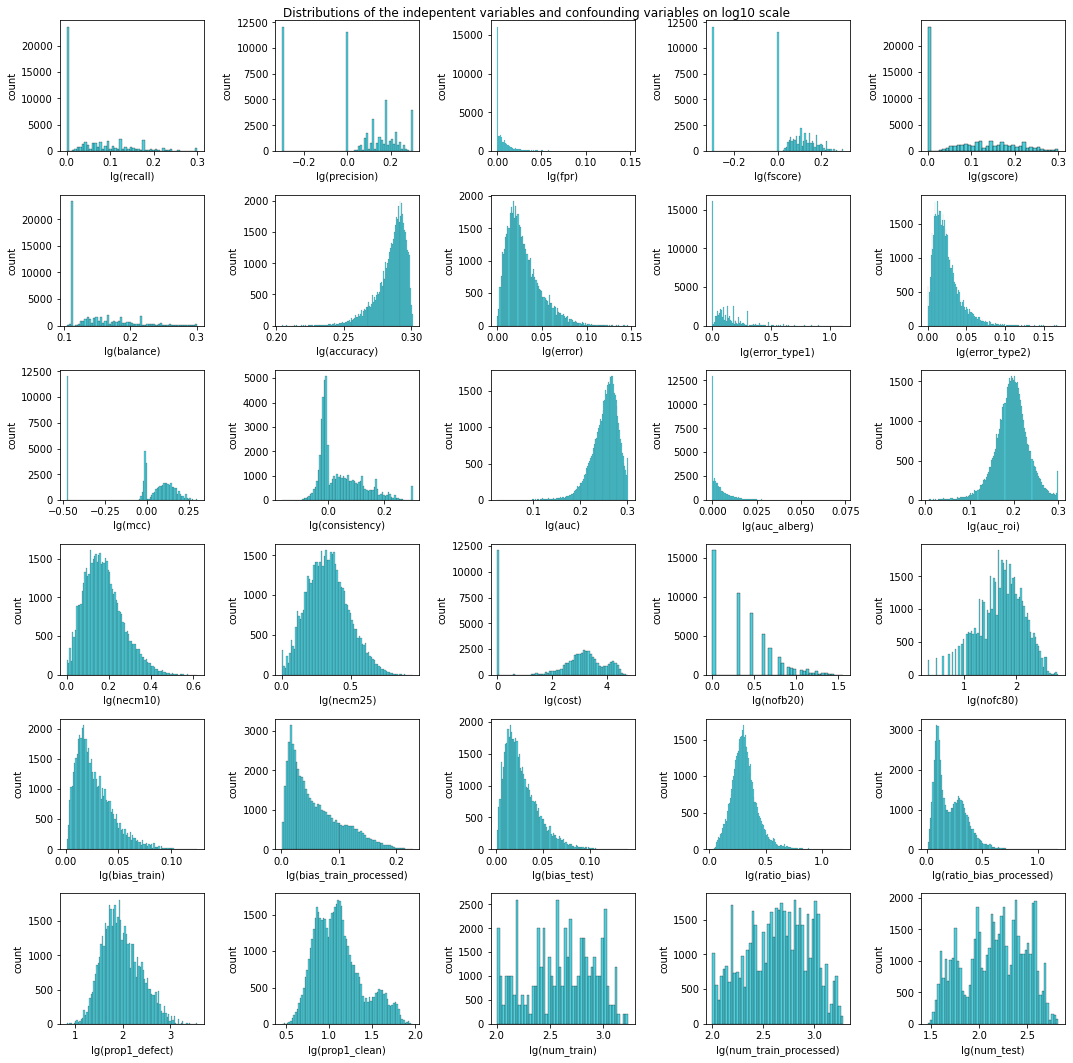

In [8]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(x=np.sign(df.iloc[:,feature_index])*np.log10(np.abs(df.iloc[:,feature_index])+1), ax=col, color="tab:cyan")
        col.set_xlabel(f"lg({df.columns[feature_index]})")
        col.set_ylabel("count")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, "dist_log_independent_and_confounding.pdf"), bbox_inches='tight')

fig.suptitle("Distributions of the indepentent variables and confounding variables on log10 scale")
plt.tight_layout()
plt.show()

### Distribution of cost saving bounds difference


Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns 24179 instances.
Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns 30 instances.


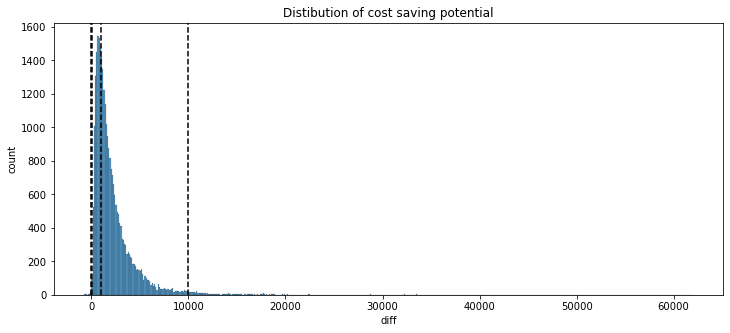

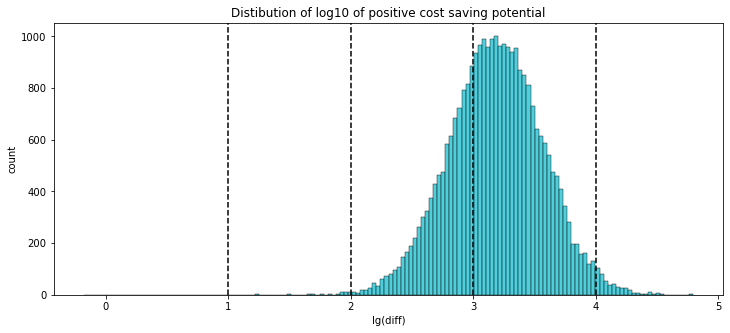

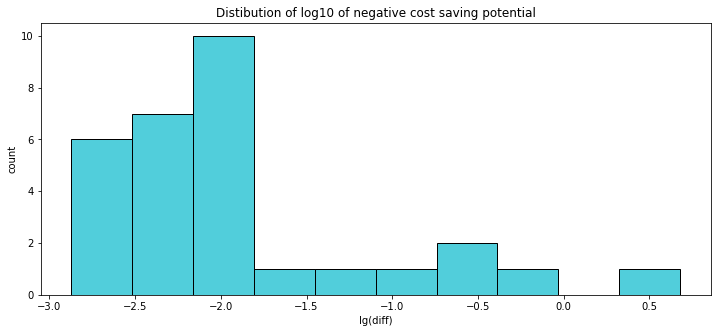

In [9]:
regular_diff = df.loc[~(df['diff'].isnull()) & ~(np.isinf(df["diff"])), 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

print(f"Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns {df.shape[0]-regular_diff.shape[0]} instances.")
print(f"Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns {neg_diff.shape[0]} instances.")


plt.figure(figsize=(12,5))
sns.histplot(data=regular_diff)
plt.ylabel("count")
plt.axvline(10, color="black", linestyle="--")
plt.axvline(100, color="black", linestyle="--")
plt.axvline(1000, color="black", linestyle="--")
plt.axvline(10000, color="black", linestyle="--")

plt.savefig(os.path.join(FIGURE_PATH, "dist_diff.pdf"), bbox_inches='tight')

plt.title("Distibution of cost saving potential")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(data=log_pos_diff, color="tab:cyan")
plt.ylabel("count")
plt.axvline(1, color="black", linestyle="--")
plt.axvline(2, color="black", linestyle="--")
plt.axvline(3, color="black", linestyle="--")
plt.axvline(4, color="black", linestyle="--")
plt.xlabel("lg(diff)")

plt.savefig(os.path.join(FIGURE_PATH, "dist_pos_log_diff.pdf"), bbox_inches='tight')

plt.title("Distibution of log10 of positive cost saving potential")
plt.show()


plt.figure(figsize=(12,5))
sns.histplot(data=log_neg_diff, color="tab:cyan")
plt.ylabel("count")
plt.xlabel("lg(diff)")

plt.savefig(os.path.join(FIGURE_PATH, "dist_neg_log_diff.pdf"), bbox_inches='tight')

plt.title("Distibution of log10 of negative cost saving potential")
plt.show()

### Variables vs lg(diff)

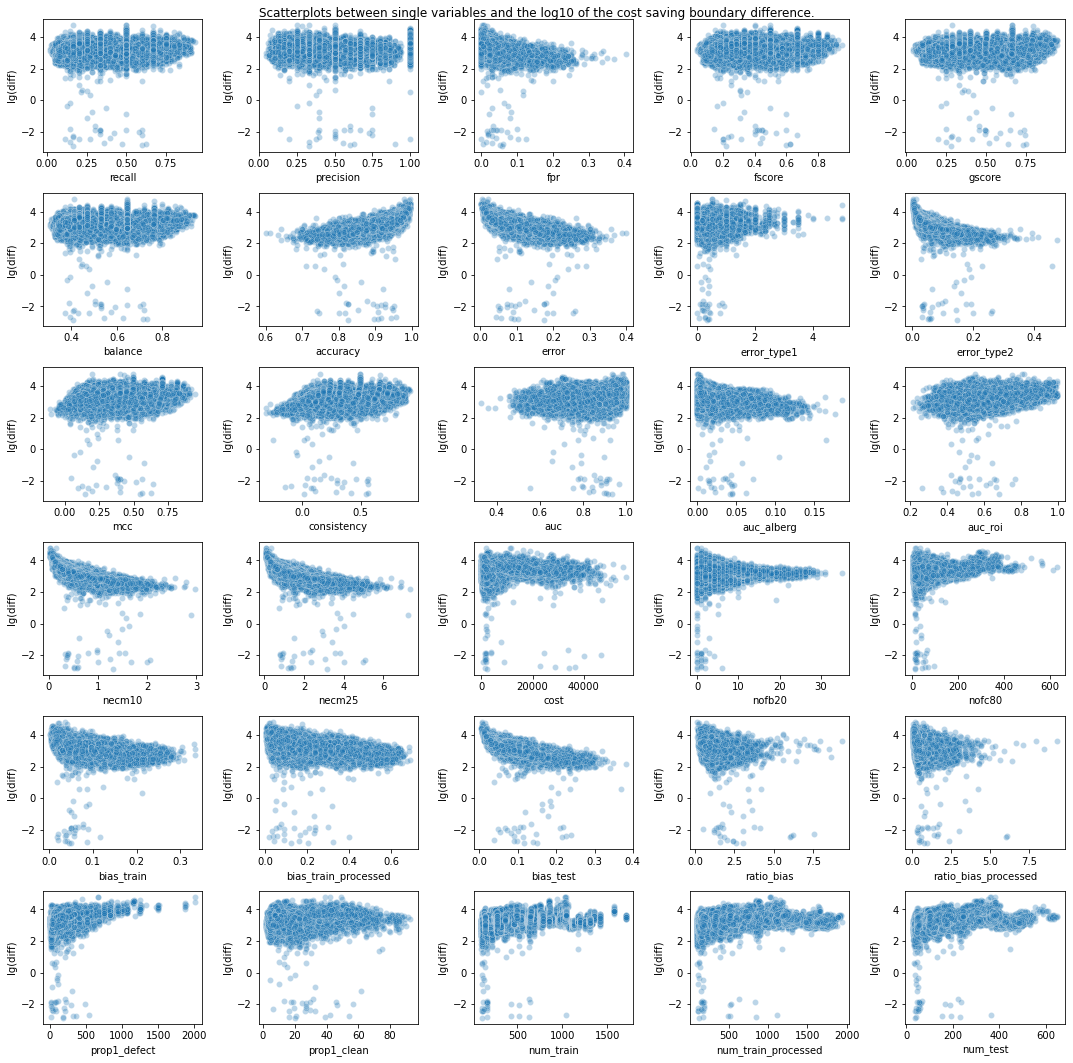

In [10]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.scatterplot(x=df.iloc[:,feature_index], y=log_diff, ax=col, alpha=0.3)
        col.set_ylabel("lg(diff)")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(FIGURE_PATH, "scatter_log_diff.pdf"), bbox_inches='tight')

fig.suptitle("Scatterplots between single variables and the log10 of the cost saving boundary difference.")
plt.tight_layout()
plt.show()

### Overall correlation Matrix
Spearman-rank correlation between all the independent and confounding variables

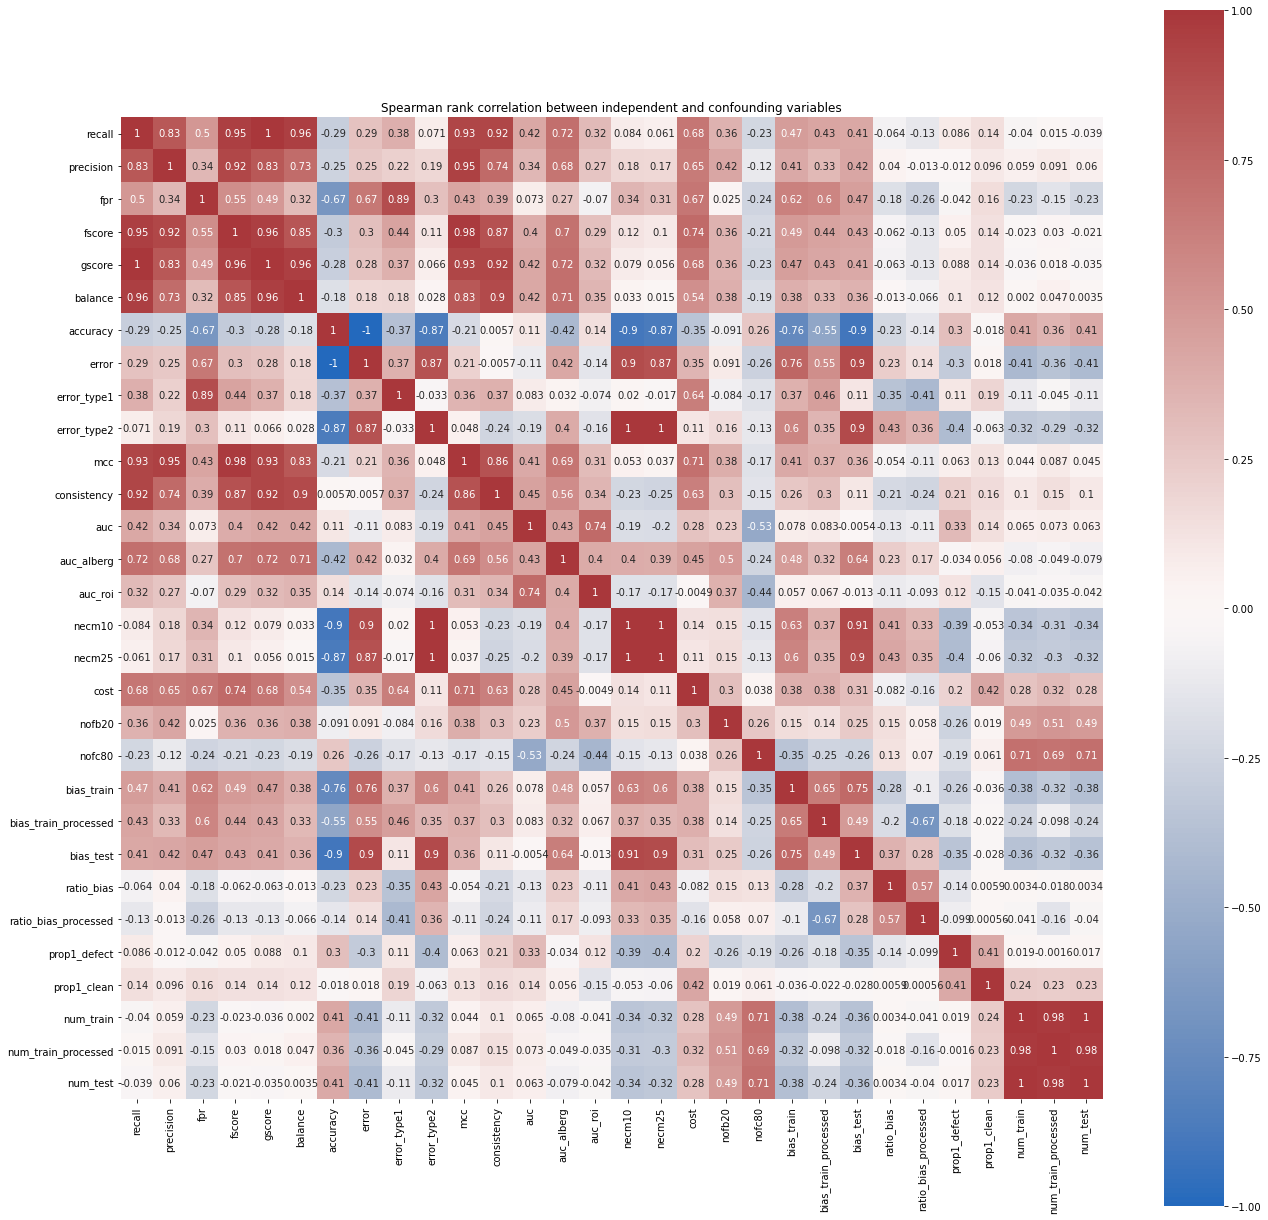

In [11]:
df_numeric = df.iloc[:,FIRST_NUM_FEATURE_IDX:FIRST_NUM_FEATURE_IDX+30]
overall_spearman_corr_map = spearmanr(a=df_numeric).correlation

plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map, square=True, annot=True, xticklabels=df_numeric.columns, yticklabels=df_numeric.columns, cmap="vlag")

plt.savefig(os.path.join(CORRELATION_DIR, "corr_all.pdf"), bbox_inches='tight')

plt.title("Spearman rank correlation between independent and confounding variables")
plt.show()

### Correlation groups
determine and plot Spearman-rank correlation groups the independent and confounding variables

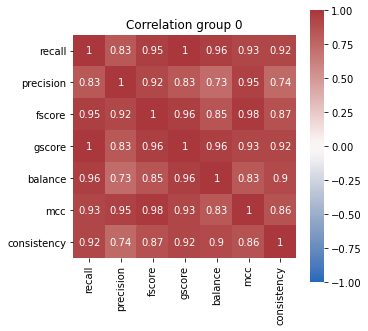

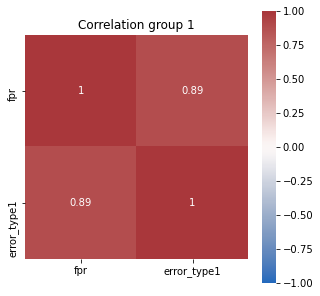

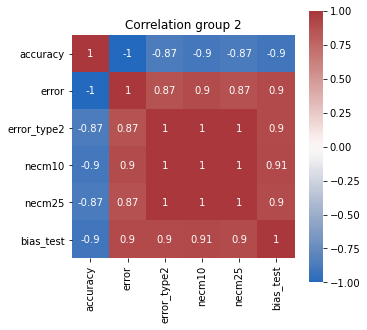

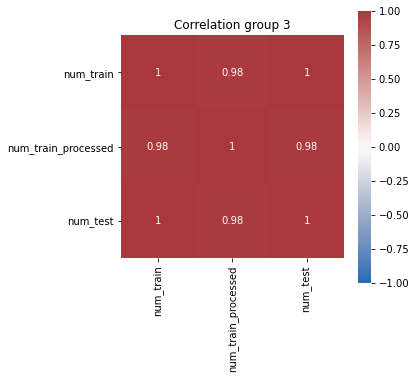

In [12]:
detect_correlation_groups(overall_spearman_corr_map, df_numeric, CORRELATION_DIR, 0.8)        

## Distribution of dependent variable: cost saving potential

To even out the class imbalance, the classes _negligible_ and _small_ are included into _medium_ by the next cell

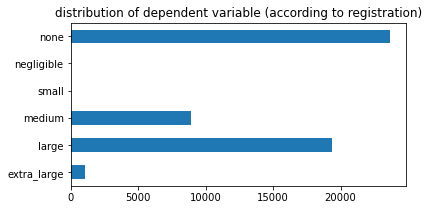

Original potential classes:
 none           23626
negligible         5
small             58
medium          8938
large          19332
extra_large     1041
Name: potential, dtype: int64 




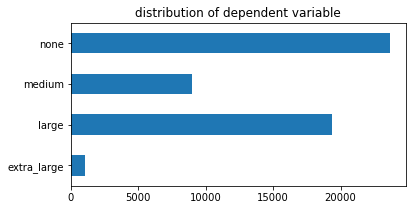

Condensed potential classes:
 none           23626
medium          9001
large          19332
extra_large     1041
Name: potential, dtype: int64 




In [13]:
original_classes = ['none','negligible','small','medium','large','extra_large']
plt.figure(figsize=(6,3))
df['potential'].value_counts()[original_classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, f"dist_dependent_original.pdf"), bbox_inches='tight')
plt.title("distribution of dependent variable (according to registration)")
plt.show()
print(f"Original potential classes:\n",df['potential'].value_counts()[original_classes], "\n\n")

# include 'negligible' and 'small' into 'medium'
df.loc[df['potential'] == 'negligible', 'potential'] = "medium"
df.loc[df['potential'] == 'small', 'potential'] = "medium"

classes = ['none','medium','large','extra_large']
plt.figure(figsize=(6,3))
df['potential'].value_counts()[classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, f"dist_dependent_updated.pdf"), bbox_inches='tight')
plt.title("distribution of dependent variable")
plt.show()
print(f"Condensed potential classes:\n",df['potential'].value_counts()[classes], "\n\n")

### Influence of preprocessing (SMOTUNED)

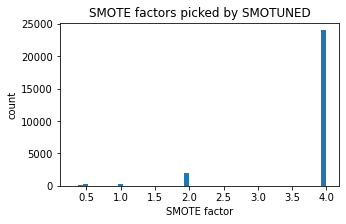

4.0    23992
2.0     1951
1.0      233
0.5      220
0.4       81
0.3       23
Name: smote, dtype: int64

In [14]:
#df_s= df.loc[df["identifier"].str.contains("SMOTUNED")]
df_s= df.loc[df["configuration"] == "Smotuned"]
df_s = df_s[["bias_train", "bias_train_processed", "num_train", "num_train_processed", "ratio_bias", "ratio_bias_processed"]]
df_s["bugs"] = df_s["bias_train"] * df_s["num_train"]
df_s["bugs_s"] = df_s["bias_train_processed"] * df_s["num_train_processed"]
df_s["smote"] = df_s["bugs_s"] / df_s["bugs"] - 1  # get the smote factor
df_s["smote"]=df_s["smote"].round(decimals=1)

plt.figure(figsize=(5,3))
df_s["smote"].plot.hist(bins=50)
plt.ylabel("count")
plt.xlabel("SMOTE factor")
plt.savefig(os.path.join(FIGURE_PATH, f"smote_factor.pdf"), bbox_inches='tight')
plt.title("SMOTE factors picked by SMOTUNED")
plt.show()

df_s["smote"].value_counts(sort=True)

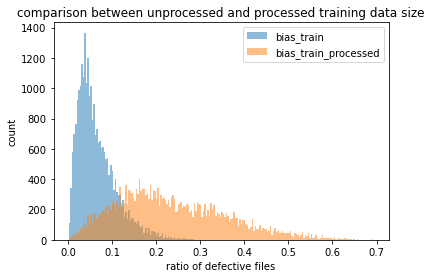

In [15]:
df_s[["bias_train", "bias_train_processed"]].plot(kind="hist", alpha=0.5, bins=200)
plt.xlabel("ratio of defective files")
plt.ylabel("count")
plt.savefig(os.path.join(FIGURE_PATH, f"smote_bias_dist.pdf"), bbox_inches='tight')
plt.title("comparison between unprocessed and processed training data size")
plt.show()

# df_s[["num_train", "num_train_processed"]].plot(kind="hist", alpha=0.6, bins=200)
# plt.ylabel("count")
# plt.title("comparison between unprocessed and processed training data size")
# plt.show()
# 
# df_s[["ratio_bias", "ratio_bias_processed"]].plot(kind="hist", alpha=0.6, bins=200)
# plt.ylabel("count")
# plt.title("comparison between unprocessed and processed training data size")
# #plt.xlim(0,2)
# plt.show()

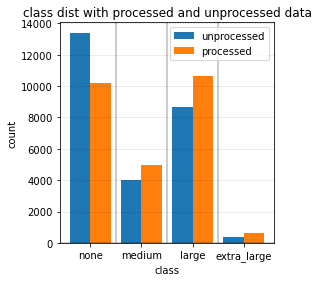

In [16]:
counts_unprocessed = df.loc[~ (df["configuration"]=="Smotuned")]['potential'].value_counts()[classes]
counts_processed = df.loc[df["configuration"]=="Smotuned"]['potential'].value_counts()[classes]
plot_data = np.asarray((counts_unprocessed,counts_processed))

bar_plot_wrapper(plot_data.T, classes, data_std=None, set_labels=["unprocessed","processed"], 
                 filename=os.path.join(FIGURE_PATH, "smote_classes_dist.pdf"), title="class dist with processed and unprocessed data",
                 xlabel="class", ylabel="count", figsize=(4, 4), rotate_ticks=False)

# #2 Evaluation Models

### Preprocessing
 - apply feature scaling
 - split dataset

In [17]:
df_features = df.drop(['release', 'configuration', 'diff','potential'], axis = 1)
y = df['potential']
X = df_features

Xmax = X.max()
Xmin = X.min()
X = (X - Xmin)/(Xmax - Xmin)

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=SPLIT_TEST_RATIO, 
                                                                         stratify=y, random_state=42)



In [18]:
train_df = X_train.copy(deep=True)
train_df["target"] = y_train
train_df.to_csv(os.path.join(DATA_PATH, "train_data.csv"), index=False)

## Logit model


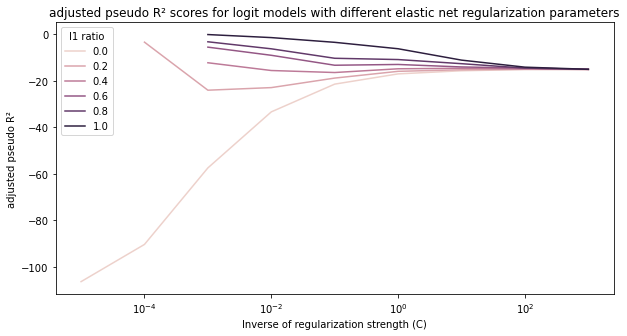

Best models sorted by adjusted pseudo R²:
         c   l1   adj_pR2  adj_weighted_pR2   num_coef       time
47  0.0010  1.0 -0.161873         -0.578291   2.000000   1.189148
48  0.0100  1.0 -1.469798         -3.270374  10.333333   1.654760
38  0.0010  0.8 -3.270860         -4.634746   7.000000   1.528465
10  0.0001  0.2 -3.433921         -3.942283   5.000000   1.600734
49  0.1000  1.0 -3.501415         -5.520749  28.000000  44.088146




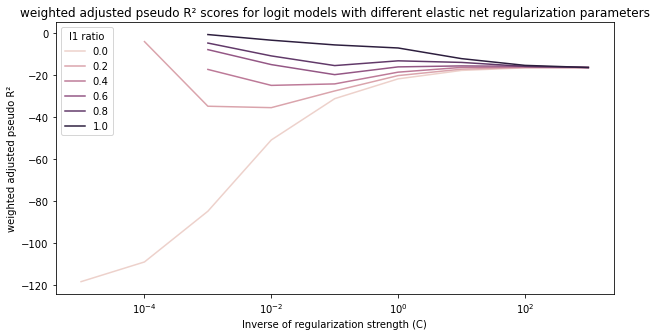

Best models sorted by weighted adjusted pseudo R²:
         c   l1   adj_pR2  adj_weighted_pR2   num_coef       time
47  0.0010  1.0 -0.161873         -0.578291   2.000000   1.189148
48  0.0100  1.0 -1.469798         -3.270374  10.333333   1.654760
10  0.0001  0.2 -3.433921         -3.942283   5.000000   1.600734
38  0.0010  0.8 -3.270860         -4.634746   7.000000   1.528465
49  0.1000  1.0 -3.501415         -5.520749  28.000000  44.088146




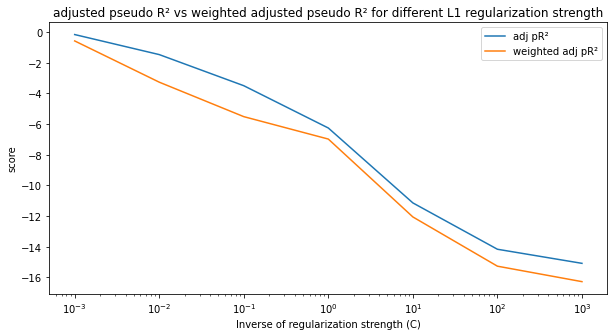

In [19]:
optim_df = pd.read_csv(os.path.join(DATA_PATH, "logit_optim_grid_search_results.csv"))
optim_df = optim_df.loc[optim_df['adj_pR2'] != -np.inf]

plt.figure(figsize=(10, 5))
sns.lineplot(data=optim_df, x="c", y="adj_pR2", hue="l1")
plt.xscale('log')
plt.legend(title="l1 ratio")
plt.xlabel("Inverse of regularization strength (C)")
plt.ylabel("adjusted pseudo R²")
plt.savefig(os.path.join(LOGIT_OPTIM_DIR, f"optim_adj_pR2.pdf"), bbox_inches='tight')
plt.title("adjusted pseudo R² scores for logit models with different elastic net regularization parameters")
plt.show()

print("Best models sorted by adjusted pseudo R²:")
print(optim_df.loc[optim_df['adj_pR2'] != -np.inf].sort_values('adj_pR2',axis=0, ascending=False).head(5))
print("\n")

plt.figure(figsize=(10, 5))
sns.lineplot(data=optim_df, x="c", y="adj_weighted_pR2", hue="l1")
plt.xscale('log')
plt.legend(title="l1 ratio")
plt.xlabel("Inverse of regularization strength (C)")
plt.ylabel("weighted adjusted pseudo R²")
plt.savefig(os.path.join(LOGIT_OPTIM_DIR, f"optim_weighted_adj_pR2.pdf"), bbox_inches='tight')
plt.title("weighted adjusted pseudo R² scores for logit models with different elastic net regularization parameters")
plt.show()

print("Best models sorted by weighted adjusted pseudo R²:")
print(optim_df.loc[optim_df['adj_weighted_pR2'] != -np.inf].sort_values('adj_weighted_pR2',axis=0, ascending=False).head(5))
print("\n")

l1_optim_df = optim_df.loc[optim_df["l1"]==1.0]
plt.figure(figsize=(10, 5))
sns.lineplot(data=l1_optim_df, x="c", y="adj_pR2")
sns.lineplot(data=l1_optim_df, x="c", y="adj_weighted_pR2")
plt.xscale('log')
plt.legend(["adj pR²","weighted adj pR²"])
plt.xlabel("Inverse of regularization strength (C)")
plt.ylabel("score")
plt.savefig(os.path.join(LOGIT_OPTIM_DIR, f"optim_compare_pR2.pdf"), bbox_inches='tight')
plt.title("adjusted pseudo R² vs weighted adjusted pseudo R² for different L1 regularization strength")
plt.show()

C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


name             LogisticRegression
training t.                0.609881
prediction t.              0.008065
recall                     0.491113
precision                  0.402487
accuracy                   0.797484
F1 measure                  0.43981
MCC                        0.698836
dtype: object


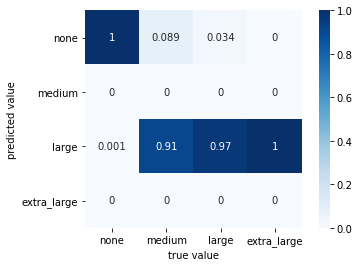

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.000000  0.965862          0.0
moderate_overprediction   0.000000  0.911481  0.000000          NaN
overall_overprediction    0.001411  0.911481  0.000000          NaN
moderate_underprediction       NaN  0.088519  0.000000          1.0
overall_underprediction        NaN  0.088519  0.034138          1.0


In [20]:
model_lr = LogisticRegression(penalty="elasticnet", solver="saga", max_iter=10000, C=0.001, l1_ratio=1.0, fit_intercept=True, random_state=42)
_, metrics_df = run_model(model_lr, "LogisticRegression", X_train, y_train, X_test, y_test, metrics_df, classes)

Number of coefficients: 3 / 120


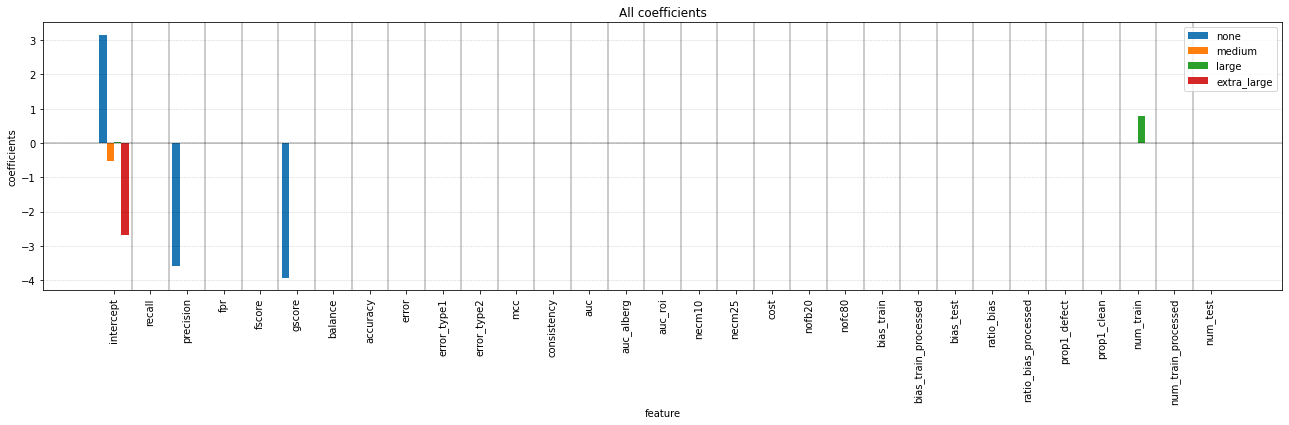

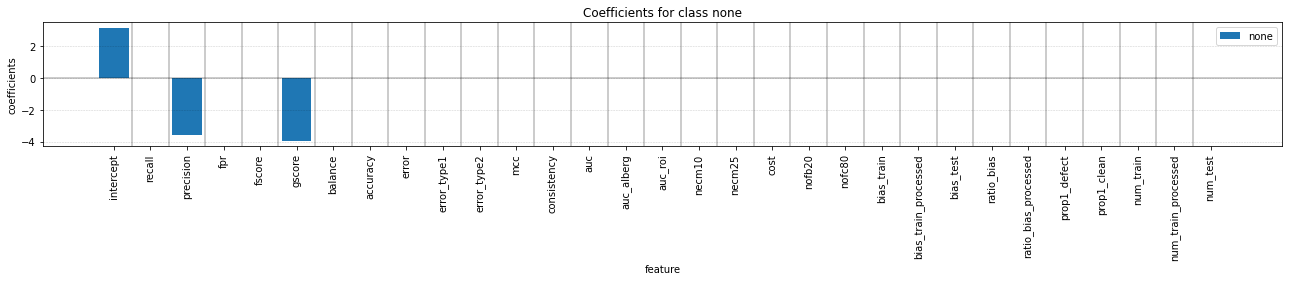

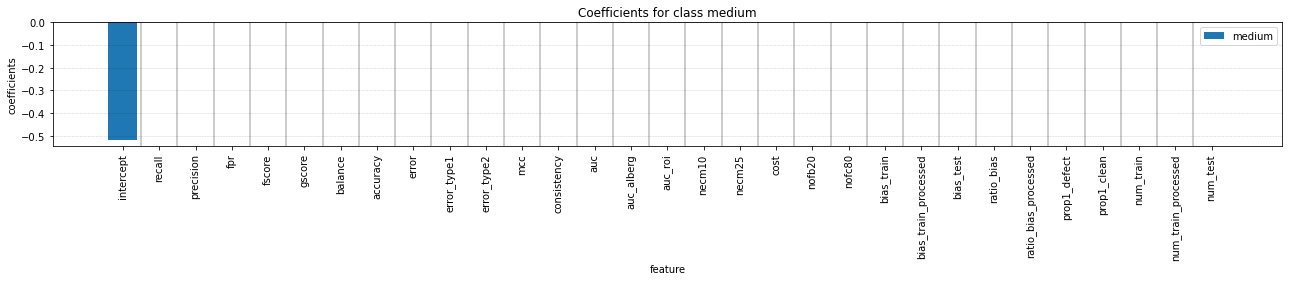

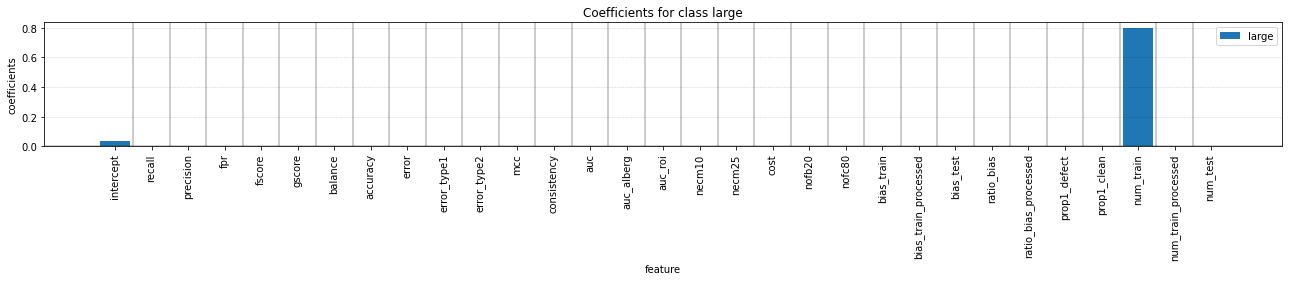

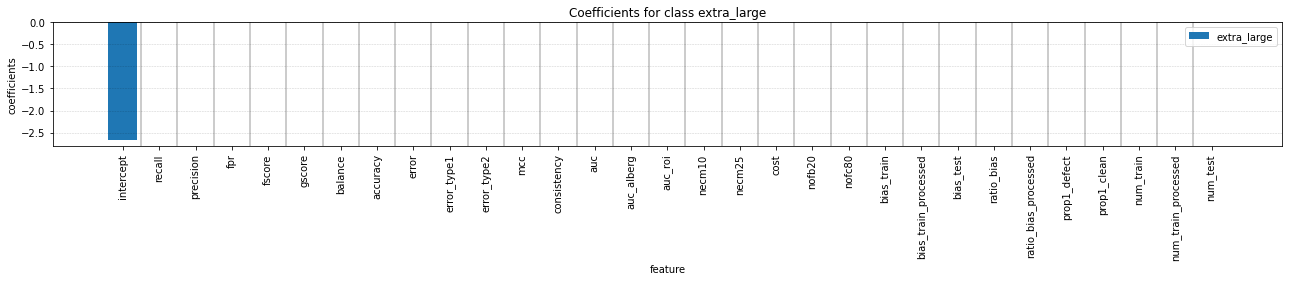

In [21]:
print(f"Number of coefficients: {np.sum(model_lr.coef_ != 0)} / {model_lr.coef_.size}")

sorted_coef = resort_coef(model_lr.coef_, model_lr.classes_, classes)
sorted_intercept = resort_coef(model_lr.intercept_, model_lr.classes_, classes)

intercept_and_coef = np.insert(sorted_coef.T, 0, sorted_intercept, axis=0).T
coef_labels = X.columns.to_list()
coef_labels.insert(0, "intercept")

bar_plot_wrapper(intercept_and_coef.T, x_labels=coef_labels, data_std=None, set_labels=classes, figsize=(18,6), filename=os.path.join(LOGIT_COEF_DIR, "coef_overall.pdf"), 
                 rotate_ticks=True, title=f"All coefficients")

for c, l in zip(intercept_and_coef, classes):
    c = c.reshape((c.shape[0],1))
    filename = os.path.join(LOGIT_COEF_DIR, f"coef_{l}.pdf")
    bar_plot_wrapper(c, x_labels=coef_labels, data_std=None, set_labels=[l], figsize=(18,4), rotate_ticks=True, filename=filename, title=f"Coefficients for class {l}")

## Decision tree model

name             DecisionTree
training t.           0.26907
prediction t.        0.008126
recall               0.859244
precision            0.900657
accuracy             0.922767
F1 measure           0.876751
MCC                  0.879388
dtype: object


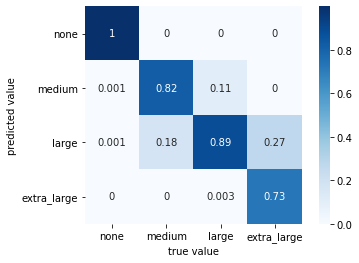

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.824444  0.886379     0.727564
moderate_overprediction   0.000847  0.175556  0.003103          NaN
overall_overprediction    0.001411  0.175556  0.003103          NaN
moderate_underprediction       NaN  0.000000  0.110517     0.272436
overall_underprediction        NaN  0.000000  0.110517     0.272436
decision tree graphic:


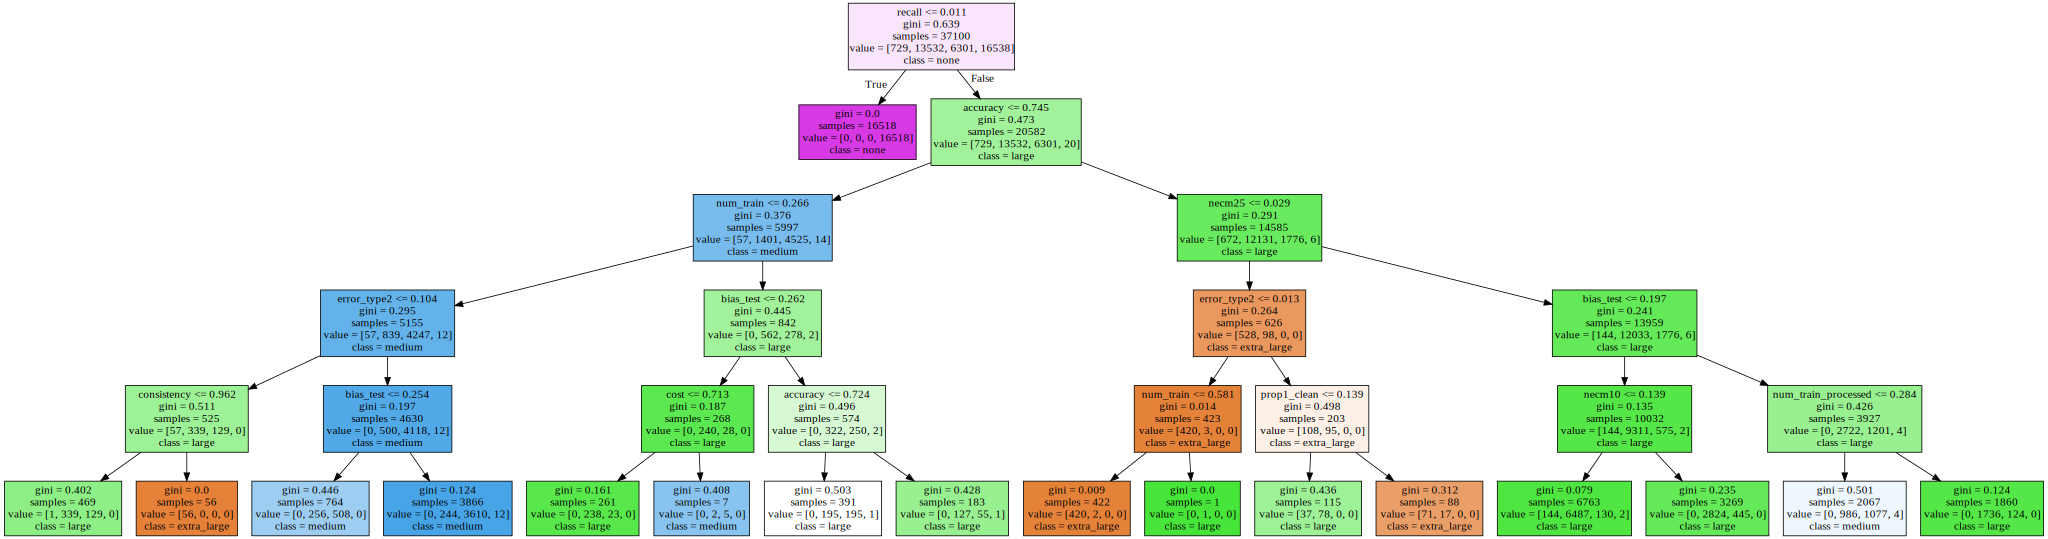

In [22]:
model_dt = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)
_, metrics_df = run_model(model_dt, "DecisionTree",X_train, y_train, X_test, y_test, metrics_df, classes)

# 1 - PLOT TREE DIRECTLY
#plt.figure(figsize=(8,1.2))
#tree.plot_tree(model_dt, filled=True)
#plt.savefig("tree.pdf", bbox_inches='tight')
#plt.show()

# 2 - PRINT TEXT REPRESENTATION
#text_representation = tree.export_text(model_dt)
#print(text_representation)

# 3 - USE GRAPHVIZ
print("decision tree graphic:")
tree.export_graphviz(model_dt,
                     out_file=os.path.join(FIGURE_PATH, 'decision_tree.dot'),
                     feature_names = X_train.columns, 
                     class_names=model_dt.classes_,
                     #class_names=classes,
                     filled = True)
dot_data = tree.export_graphviz(model_dt,
                     feature_names = X_train.columns, 
                     class_names=model_dt.classes_,
                     filled = True)
#print(dot_data)
#! dot -Tpdf tree.dot -o tree.pdf
os.system(f"dot -Tpdf {os.path.join(FIGURE_PATH, 'decision_tree.dot')} -o {os.path.join(FIGURE_PATH, 'decision_tree.pdf')}")

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

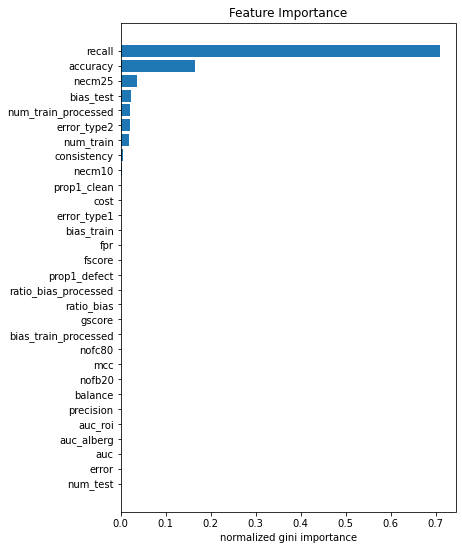

feature  importance
0                recall    0.708542
6              accuracy    0.164104
16               necm25    0.036688
22            bias_test    0.023546
28  num_train_processed    0.020580
9           error_type2    0.020052
27            num_train    0.018393
11          consistency    0.004042
15               necm10    0.002592
26          prop1_clean    0.001189
17                 cost    0.000271

In [23]:
dt_feature_importance = model_dt.tree_.compute_feature_importances(normalize=True)

dt_feat_importance_dict = {'feature': X.columns,
                      'importance': dt_feature_importance}
dt_feat_importance_df = pd.DataFrame(dt_feat_importance_dict)
dt_feat_importance_df.sort_values("importance", axis=0, ascending=False, inplace=True)


plt.figure(figsize=(6,9))
plt.barh(dt_feat_importance_df["feature"], dt_feat_importance_df["importance"])
plt.xlabel("normalized gini importance")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, "dt_feature_importance.pdf"), bbox_inches="tight")
plt.title("Feature Importance")
plt.show()

dt_feat_importance_df.loc[dt_feat_importance_df['importance'] != 0]

## Random forest model

In [24]:
def rf_optimizer_function(x):
    """compute loss (-MCC) for Random Forest model with specific set of hyperparameters."""
    
    min_samples_leaf = int(x[0])
    min_samples_split = int(x[1])
    max_features = x[2]
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
                                   max_features=max_features, n_jobs=-1, random_state=42)
    mcc_scorer = make_scorer(matthews_corrcoef)
    mcc_scores =cross_val_score(model, X_train, y_train, cv=3, scoring=mcc_scorer)
    return -1 * mcc_scores.mean()

t0 = time.time()
bounds = [(1,21), (2,21), (0.000001, 1.0)]
result_rf = differential_evolution(rf_optimizer_function, bounds, maxiter=3, popsize=4, mutation=0.9, recombination=0.5,
                                   init="random", strategy="rand1bin", disp=True, polish=False, seed=42,
                                   updating="immediate", tol=0.00000000001, atol=0.000000001)
print(result_rf)
print(f"time needed: {time.time()-t0}")
min_s_leaf = int(result_rf.x[0])
min_s_split = int(result_rf.x[1])
max_f = result_rf.x[2]

differential_evolution step 1: f(x)= -0.912574
differential_evolution step 2: f(x)= -0.912574
differential_evolution step 3: f(x)= -0.912574
     fun: -0.9125738933059292
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 48
     nit: 3
 success: False
       x: array([3.78987721, 7.55074832, 0.36636248])
time needed: 214.5901801586151


name             PlainRandomForest
training t.                0.87076
prediction t.             0.062491
recall                    0.905051
precision                 0.920396
accuracy                  0.946792
F1 measure                0.912461
MCC                       0.916633
dtype: object


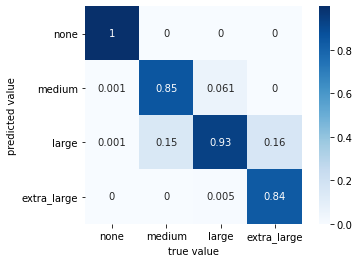

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.851111  0.933966     0.836538
moderate_overprediction   0.000564  0.148889  0.005345          NaN
overall_overprediction    0.001411  0.148889  0.005345          NaN
moderate_underprediction       NaN  0.000000  0.060690     0.163462
overall_underprediction        NaN  0.000000  0.060690     0.163462


Tuned hyperparameters:
min_samples_leaf: 3	min_samples_split: 7	max_features: 0.36636247693184837
name             TunedRandomForest
training t.               1.447266
prediction t.             0.041287
recall                    0.904627
precision                 0.921971
accuracy                  0.947736
F1 measure                0.912958
MCC                       0.918107
dtype: object


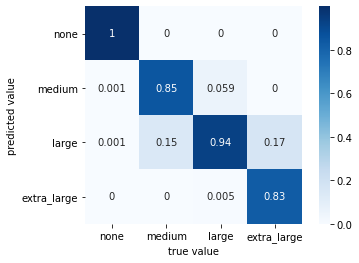

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.854444  0.935345     0.830128
moderate_overprediction   0.000564  0.145556  0.005172          NaN
overall_overprediction    0.001411  0.145556  0.005172          NaN
moderate_underprediction       NaN  0.000000  0.059483     0.169872
overall_underprediction        NaN  0.000000  0.059483     0.169872


In [25]:
plain_rf = RandomForestClassifier(n_jobs=-1, random_state=42)
_, metrics_df = run_model(plain_rf, "PlainRandomForest",X_train, y_train, X_test, y_test, metrics_df, classes)

print("\n")

print(f"Tuned hyperparameters:")
print(f"min_samples_leaf: {min_s_leaf}\tmin_samples_split: {min_s_split}\tmax_features: {max_f}")
model_rf = RandomForestClassifier(min_samples_leaf=min_s_leaf, min_samples_split=min_s_split, max_features=max_f, 
                                  n_jobs=-1, random_state=42)
_, metrics_df = run_model(model_rf, "TunedRandomForest",X_train, y_train, X_test, y_test, metrics_df, classes)

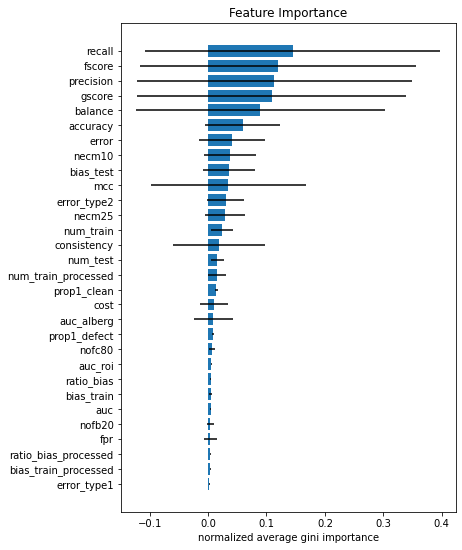

feature      mean       std
0                 recall  0.144910  0.252605
3                 fscore  0.119471  0.235753
1              precision  0.113220  0.235354
4                 gscore  0.108758  0.229652
5                balance  0.089405  0.212953
6               accuracy  0.058952  0.064536
7                  error  0.040318  0.056415
15                necm10  0.037141  0.044295
22             bias_test  0.035736  0.044479
10                   mcc  0.034839  0.133306
9            error_type2  0.030073  0.031831
16                necm25  0.029341  0.033889
27             num_train  0.023237  0.018757
11           consistency  0.018757  0.078612
29              num_test  0.016090  0.011308
28   num_train_processed  0.015399  0.015677
26           prop1_clean  0.014269  0.002886
17                  cost  0.009950  0.024252
13            auc_alberg  0.009043  0.032945
25          prop1_defect  0.007780  0.001859
19                nofc80  0.006497  0.004817
14               auc_roi  0.005793  0.001214
23            ratio_bias  0.004674  0.001117
20            bias_train  0.004452  0.002228
12                   auc  0.004446  0.001016
18                nofb20  0.004033  0.005314
2                    fpr  0.003954  0.010679
24  ratio_bias_processed  0.003765  0.001251
21  bias_train_processed  0.003564  0.000927
8            error_type1  0.002135  0.000757

In [26]:
rf_feat_importance = model_rf.feature_importances_
rf_feat_importance_std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
rf_feat_importance_dict = {'feature': X.columns,
                      'mean': rf_feat_importance,
                          'std': rf_feat_importance_std}
rf_feat_importance_df = pd.DataFrame(rf_feat_importance_dict)
rf_feat_importance_df.sort_values("mean", axis=0, ascending=False, inplace=True)

plt.figure(figsize=(6,9))
plt.barh(rf_feat_importance_df["feature"], rf_feat_importance_df["mean"], xerr=rf_feat_importance_df["std"])
plt.xlabel("normalized average gini importance")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, "rf_feature_importance.pdf"), bbox_inches="tight")
plt.title("Feature Importance")
plt.show()

rf_feat_importance_df.loc[rf_feat_importance_df['mean'] != 0]

## Performance overview

In [27]:
metrics_df

name  training t.  prediction t.    recall  precision  \
0  LogisticRegression     0.609881       0.008065  0.491113   0.402487   
1        DecisionTree     0.269070       0.008126  0.859244   0.900657   
2   PlainRandomForest     0.870760       0.062491  0.905051   0.920396   
3   TunedRandomForest     1.447266       0.041287  0.904627   0.921971   

   accuracy  F1 measure       MCC  
0  0.797484    0.439810  0.698836  
1  0.922767    0.876751  0.879388  
2  0.946792    0.912461  0.916633  
3  0.947736    0.912958  0.918107

# #3 Confirmatory Analysis

In [28]:
X_select = X[["recall", "accuracy"]]

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_select, y, indices, test_size=SPLIT_TEST_RATIO, 
                                                                         stratify=y, random_state=42)

C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


name             ConfirmLogisticRegression
training t.                       0.158337
prediction t.                          0.0
recall                            0.427449
precision                         0.347183
accuracy                          0.704591
F1 measure                        0.382368
MCC                               0.525481
dtype: object


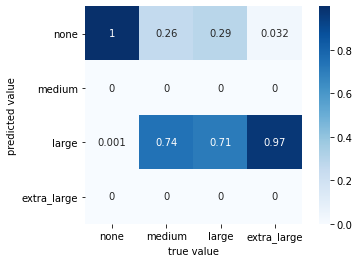

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.000000  0.711207     0.000000
moderate_overprediction   0.000000  0.741852  0.000000          NaN
overall_overprediction    0.001411  0.741852  0.000000          NaN
moderate_underprediction       NaN  0.258148  0.000000     0.967949
overall_underprediction        NaN  0.258148  0.288793     1.000000
Number of coefficients: 1 / 8


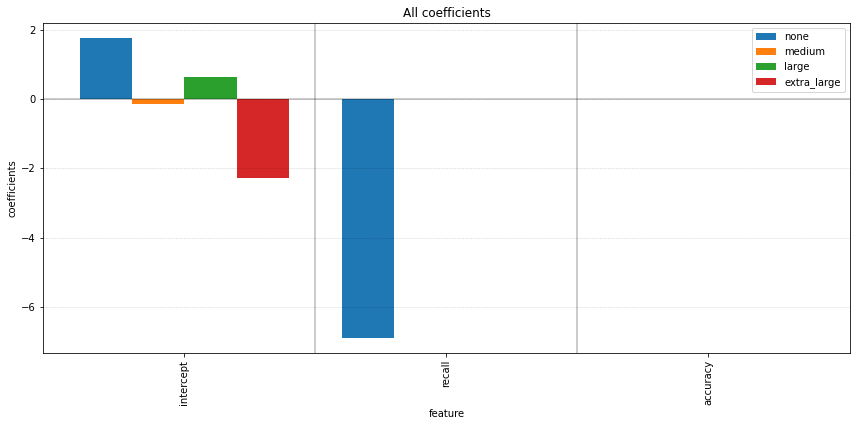

In [29]:
model_lr_small = LogisticRegression(penalty="elasticnet", solver="saga", max_iter=10000, C=0.001, l1_ratio=1, fit_intercept=True, random_state=42)
_, metrics_df = run_model(model_lr_small, "ConfirmLogisticRegression", X_train, y_train, X_test, y_test, metrics_df, classes)

print(f"Number of coefficients: {np.sum(model_lr_small.coef_ != 0)} / {model_lr_small.coef_.size}")

sorted_coef = resort_coef(model_lr_small.coef_, model_lr_small.classes_, classes)
sorted_intercept = resort_coef(model_lr_small.intercept_, model_lr_small.classes_, classes)

intercept_and_coef = np.insert(sorted_coef.T, 0, sorted_intercept, axis=0).T
coef_labels = X_select.columns.to_list()
coef_labels.insert(0, "intercept")

bar_plot_wrapper(intercept_and_coef.T, x_labels=coef_labels, data_std=None, set_labels=classes, figsize=(12,6), filename=os.path.join(LOGIT_COEF_DIR, "confirm_coef_overall.pdf"), 
                 rotate_ticks=True, title=f"All coefficients")

name             ConfirmDecisionTree
training t.                 0.044272
prediction t.               0.002082
recall                      0.825758
precision                   0.885052
accuracy                    0.909937
F1 measure                  0.850525
MCC                         0.859226
dtype: object


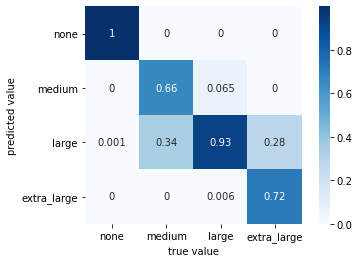

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.656667  0.929828     0.717949
moderate_overprediction   0.000282  0.343333  0.005517          NaN
overall_overprediction    0.001411  0.343333  0.005517          NaN
moderate_underprediction       NaN  0.000000  0.064655     0.282051
overall_underprediction        NaN  0.000000  0.064655     0.282051
decision tree graphic:


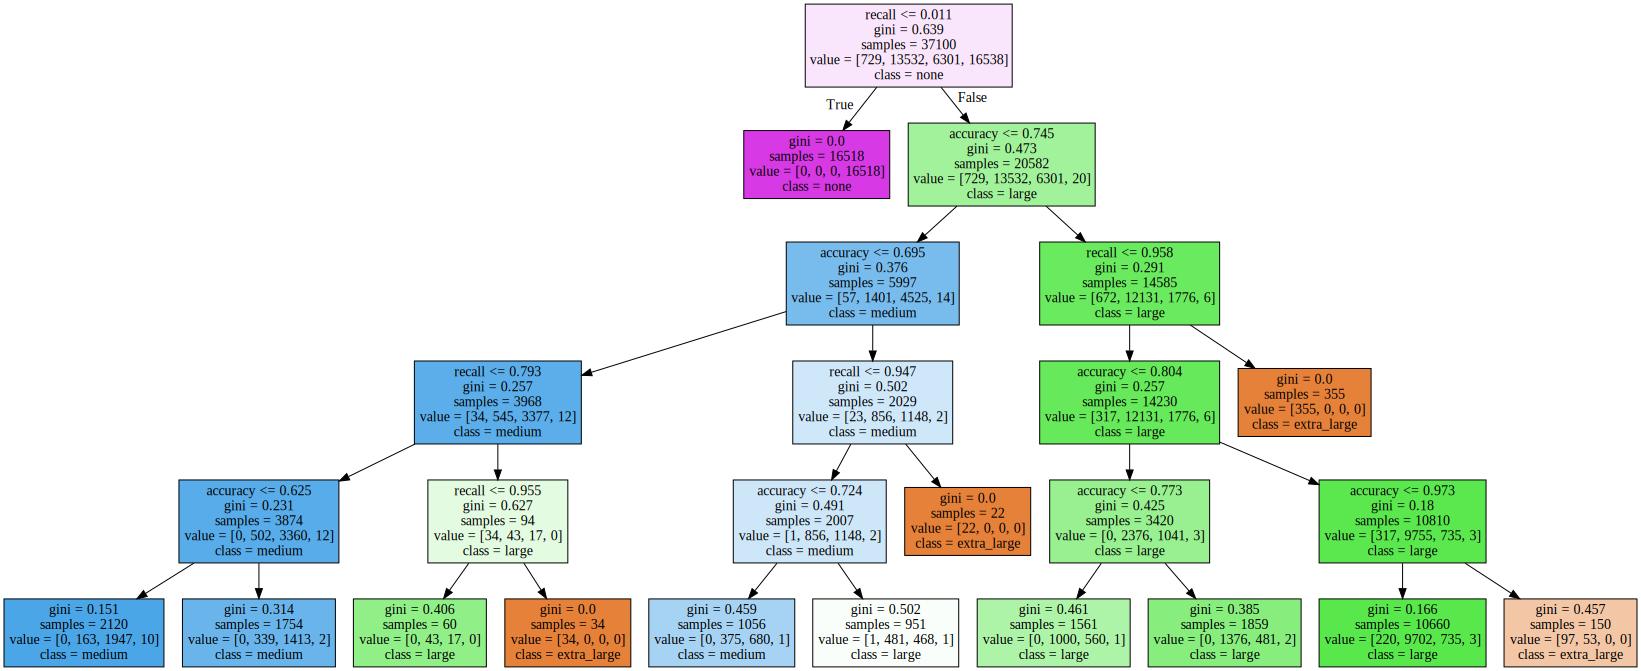

In [30]:
model_dt_small = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)
_, metrics_df = run_model(model_dt_small, "ConfirmDecisionTree",X_train, y_train, X_test, y_test, metrics_df, classes)


# 3 - USE GRAPHVIZ
print("decision tree graphic:")
tree.export_graphviz(model_dt_small,
                     out_file=os.path.join(FIGURE_PATH, 'confirm_decision_tree.dot'),
                     feature_names = X_train.columns, 
                     class_names=model_dt_small.classes_,
                     #class_names=classes,
                     filled = True)
dot_data = tree.export_graphviz(model_dt_small,
                     feature_names = X_train.columns, 
                     class_names=model_dt_small.classes_,
                     filled = True)
#print(dot_data)
#! dot -Tpdf tree.dot -o tree.pdf
os.system(f"dot -Tpdf {os.path.join(FIGURE_PATH, 'confirm_decision_tree.dot')} -o {os.path.join(FIGURE_PATH, 'confirm_decision_tree.pdf')}")

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

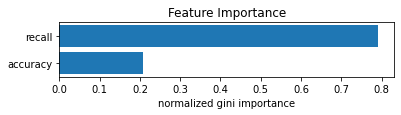

feature  importance
0    recall    0.791383
1  accuracy    0.208617

In [31]:
dt_feature_importance = model_dt_small.tree_.compute_feature_importances(normalize=True)

dt_feat_importance_dict = {'feature': X_select.columns,
                      'importance': dt_feature_importance}
dt_feat_importance_df = pd.DataFrame(dt_feat_importance_dict)
dt_feat_importance_df.sort_values("importance", axis=0, ascending=False, inplace=True)


plt.figure(figsize=(6,1))
plt.barh(dt_feat_importance_df["feature"], dt_feat_importance_df["importance"])
plt.xlabel("normalized gini importance")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, "confirm_dt_feature_importance.pdf"), bbox_inches="tight")
plt.title("Feature Importance")
plt.show()

dt_feat_importance_df.loc[dt_feat_importance_df['importance'] != 0]

differential_evolution step 1: f(x)= -0.858145
differential_evolution step 2: f(x)= -0.858145
differential_evolution step 3: f(x)= -0.858145
     fun: -0.858144679138617
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 48
     nit: 3
 success: False
       x: array([15.16145156,  2.39110539,  0.96990988])
time needed: 38.82428216934204


name             ConfirmPlainRandomForest
training t.                      0.418048
prediction t.                    0.036211
recall                           0.825887
precision                        0.843133
accuracy                         0.896792
F1 measure                       0.834119
MCC                              0.838205
dtype: object


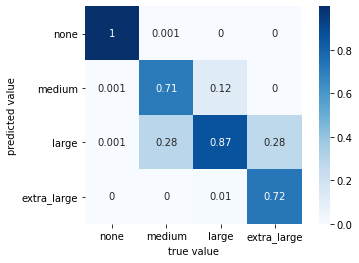

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.713704  0.866897     0.724359
moderate_overprediction   0.000564  0.285185  0.010345          NaN
overall_overprediction    0.001411  0.285185  0.010345          NaN
moderate_underprediction       NaN  0.001111  0.122759     0.275641
overall_underprediction        NaN  0.001111  0.122759     0.275641


Tuned hyperparameters:
min_samples_leaf: 15	min_samples_split: 2	max_features: 0.9699098822521421
name             ConfirmTunedRandomForest
training t.                      0.389103
prediction t.                    0.053427
recall                            0.83081
precision                        0.894919
accuracy                         0.915472
F1 measure                       0.858107
MCC                              0.867378
dtype: object


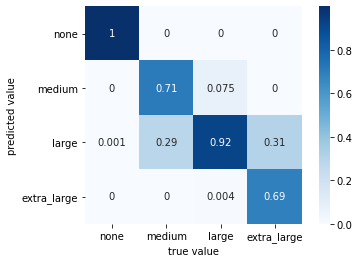

                              none    medium     large  extra_large
correctly_predicted       0.998589  0.711481  0.920862     0.692308
moderate_overprediction   0.000282  0.288519  0.003793          NaN
overall_overprediction    0.001411  0.288519  0.003793          NaN
moderate_underprediction       NaN  0.000000  0.075345     0.307692
overall_underprediction        NaN  0.000000  0.075345     0.307692


In [32]:
def rf_optimizer_function(x):
    """compute loss (-MCC) for Random Forest model with specific set of hyperparameters."""
    
    min_samples_leaf = int(x[0])
    min_samples_split = int(x[1])
    max_features = x[2]
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, 
                                   max_features=max_features, n_jobs=-1, random_state=42)
    mcc_scorer = make_scorer(matthews_corrcoef)
    mcc_scores =cross_val_score(model, X_train, y_train, cv=3, scoring=mcc_scorer)
    return -1 * mcc_scores.mean()

t0 = time.time()
bounds = [(1,21), (2,21), (0.000001, 1.0)]
result_rf = differential_evolution(rf_optimizer_function, bounds, maxiter=3, popsize=4, mutation=0.9, recombination=0.5,
                                   init="random", strategy="rand1bin", disp=True, polish=False, seed=42,
                                   updating="immediate", tol=0.00000000001, atol=0.000000001)
print(result_rf)
print(f"time needed: {time.time()-t0}")
min_s_leaf = int(result_rf.x[0])
min_s_split = int(result_rf.x[1])
max_f = result_rf.x[2]

print("\n")

plain_rf = RandomForestClassifier(n_jobs=-1, random_state=42)
_, metrics_df = run_model(plain_rf, "ConfirmPlainRandomForest",X_train, y_train, X_test, y_test, metrics_df, classes)

print("\n")

print(f"Tuned hyperparameters:")
print(f"min_samples_leaf: {min_s_leaf}\tmin_samples_split: {min_s_split}\tmax_features: {max_f}")
model_rf_small = RandomForestClassifier(min_samples_leaf=min_s_leaf, min_samples_split=min_s_split, max_features=max_f, 
                                  n_jobs=-1, random_state=42)
_, metrics_df = run_model(model_rf_small, "ConfirmTunedRandomForest",X_train, y_train, X_test, y_test, metrics_df, classes)

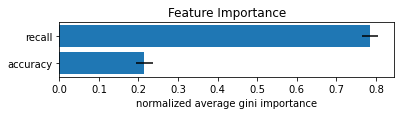

feature      mean       std
0    recall  0.785138  0.020621
1  accuracy  0.214862  0.020621

In [33]:
rf_feat_importance = model_rf_small.feature_importances_
rf_feat_importance_std = np.std([tree.feature_importances_ for tree in model_rf_small.estimators_], axis=0)
rf_feat_importance_dict = {'feature': X_select.columns,
                      'mean': rf_feat_importance,
                          'std': rf_feat_importance_std}
rf_feat_importance_df = pd.DataFrame(rf_feat_importance_dict)
rf_feat_importance_df.sort_values("mean", axis=0, ascending=False, inplace=True)

plt.figure(figsize=(6,1))
plt.barh(rf_feat_importance_df["feature"], rf_feat_importance_df["mean"], xerr=rf_feat_importance_df["std"])
plt.xlabel("normalized average gini importance")
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, "confirm_rf_feature_importance.pdf"), bbox_inches="tight")
plt.title("Feature Importance")
plt.show()

rf_feat_importance_df.loc[rf_feat_importance_df['mean'] != 0]

In [34]:
metrics_df

name  training t.  prediction t.    recall  precision  \
0         LogisticRegression     0.609881       0.008065  0.491113   0.402487   
1               DecisionTree     0.269070       0.008126  0.859244   0.900657   
2          PlainRandomForest     0.870760       0.062491  0.905051   0.920396   
3          TunedRandomForest     1.447266       0.041287  0.904627   0.921971   
4  ConfirmLogisticRegression     0.158337       0.000000  0.427449   0.347183   
5        ConfirmDecisionTree     0.044272       0.002082  0.825758   0.885052   
6   ConfirmPlainRandomForest     0.418048       0.036211  0.825887   0.843133   
7   ConfirmTunedRandomForest     0.389103       0.053427  0.830810   0.894919   

   accuracy  F1 measure       MCC  
0  0.797484    0.439810  0.698836  
1  0.922767    0.876751  0.879388  
2  0.946792    0.912461  0.916633  
3  0.947736    0.912958  0.918107  
4  0.704591    0.382368  0.525481  
5  0.909937    0.850525  0.859226  
6  0.896792    0.834119  0.838205  
7  0.915472    0.858107  0.867378

# #4 Generalization


In [35]:
df_real = pd.read_csv(os.path.join(DATA_PATH, "metrics_vs_costsaving_realistic_settings.csv"), index_col=0)
print(f"Shape of the dataset: {df_real.shape}")

dataset_overview(df_real)

Shape of the dataset: (1491, 34)
Number of releases: 265
Instances per release: [3, 6]
Total number of instances: 1491
Rows containing NaN values: 0


In [36]:
dataset_descriptive_stats(df_real)

configuration  release    recall  precision       fpr    fscore  \
mean              NaN      NaN  0.602904   0.261316  0.241595  0.296018   
std               NaN      NaN  0.268155   0.260275  0.282844  0.226089   
min               NaN      NaN  0.000000  -1.000000  0.000000 -1.000000   
max               NaN      NaN  1.000000   1.000000  1.000000  1.000000   
median            NaN      NaN  0.615385   0.177778  0.134199  0.250000   
25q               NaN      NaN  0.400000   0.096774  0.055954  0.155428   
75q               NaN      NaN  0.818182   0.333333  0.272623  0.364229   

          gscore   balance  accuracy     error  error_type1  error_type2  \
mean    0.563897  0.607340  0.743958  0.225620     5.090257     0.030346   
std     0.248905  0.172535  0.260675  0.198899     8.341107     0.032797   
min     0.000000  0.290605  0.005517  0.000000     0.000000     0.000000   
max     1.000000  1.000000  1.000000  0.932549    86.181818     0.243902   
median  0.612382  0.612661  0.839286  0.160714     2.230769     0.019640   
25q     0.433274  0.487061  0.727166  0.090808     0.743190     0.007345   
75q     0.746217  0.735549  0.909192  0.272727     5.800000     0.043547   

             mcc  consistency       auc  auc_alberg   auc_roi    necm10  \
mean    0.185072     0.632560  0.772829    0.011852  0.571838  0.472376   
std     0.498029     0.438056  0.142922    0.019559  0.137733  0.276838   
min    -2.000000    -0.196283  0.169096    0.000000  0.126243  0.000000   
max     1.000000     3.126050  1.000000    0.143499  0.991099  1.961165   
median  0.220835     0.589828  0.798387    0.003925  0.544554  0.431802   
25q     0.117715     0.361040  0.702706    0.000000  0.486509  0.275641   
75q     0.338401     0.801991  0.873355    0.013937  0.640182  0.629269   

          necm25           cost      nofb20       nofc80  bias_train  \
mean    0.883636   36177.304494    8.649899   210.416499    0.061907   
std     0.650931   44106.944261   10.675106   216.847189    0.029243   
min     0.000000       0.000000    0.000000     4.000000    0.009390   
max     4.873786  197221.000000  128.000000  1663.000000    0.219858   
median  0.709350   17653.000000    6.000000   145.000000    0.055827   
25q     0.450706    8208.000000    2.000000    61.500000    0.054524   
75q     1.153585   39708.500000   11.000000   266.000000    0.059086   

        bias_train_processed  bias_test  ratio_bias  ratio_bias_processed  \
mean                0.062209   0.065972    1.172156              1.173822   
std                 0.029348   0.041289    0.950077              1.008191   
min                 0.006472   0.007042    0.124166              0.124166   
max                 0.224638   0.219858    9.774485             16.326031   
median              0.055827   0.056911    0.924699              0.922616   
25q                 0.054524   0.035963    0.688235              0.679365   
75q                 0.059086   0.088578    1.393639              1.384755   

        prop1_defect  prop1_clean      num_train  num_train_processed  \
mean       77.067325    14.269304   67635.189135         67624.089873   
std        89.346904    11.450189   63045.391289         63057.188328   
min         5.678571     2.542857     100.000000            81.000000   
max       682.181818    50.171569  134119.000000        134119.000000   
median     48.117647     9.622047  110923.000000        110923.000000   
25q        25.115385     7.279539     448.000000           430.000000   
75q        93.465116    14.150573  127184.000000        127184.000000   

           num_test         diff  potential  
mean     514.036217          NaN        NaN  
std      342.277561          NaN        NaN  
min      100.000000         -inf        NaN  
max     1708.000000          inf        NaN  
median   431.000000   327.332143        NaN  
25q      240.000000  -523.538889        NaN  
75q      725.000000  3004.507143        NaN

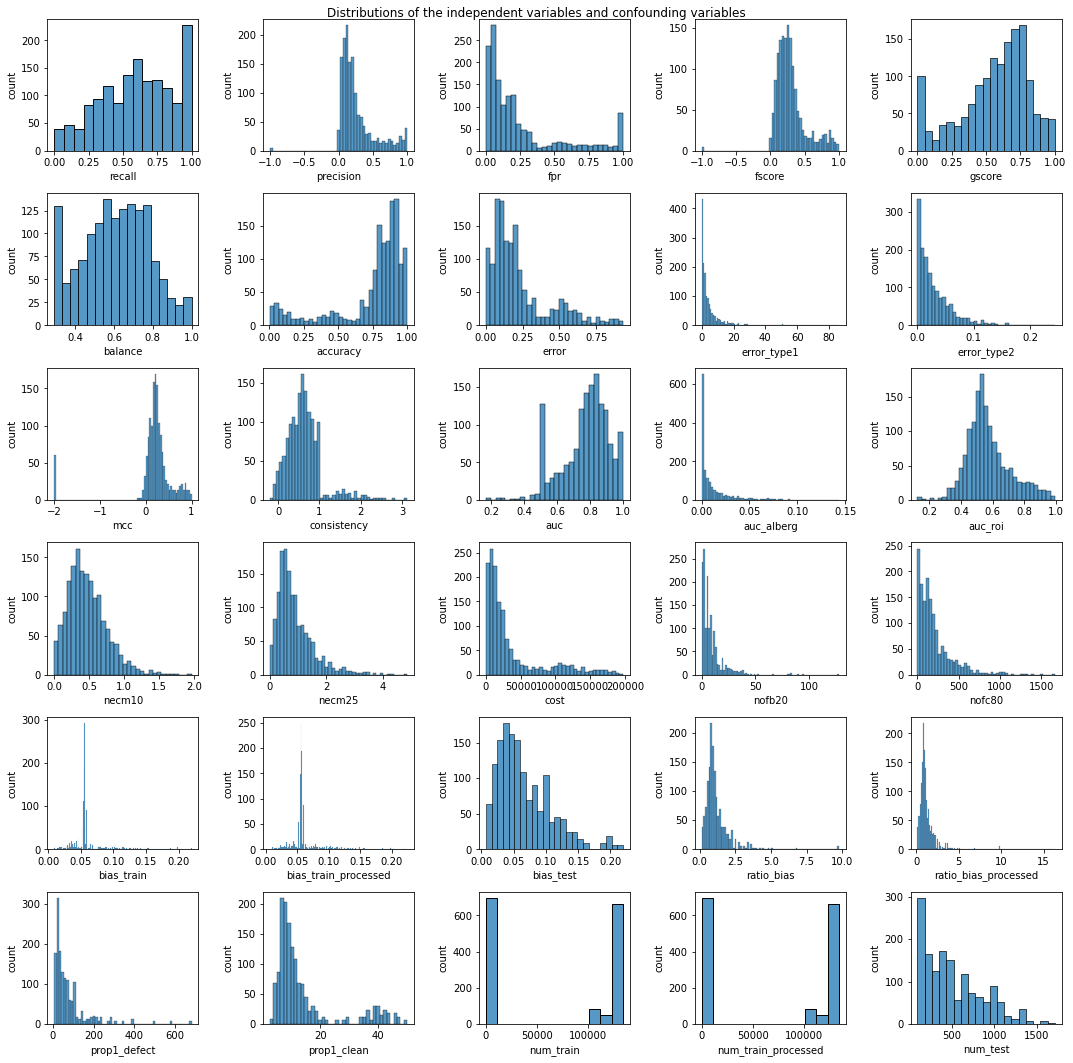

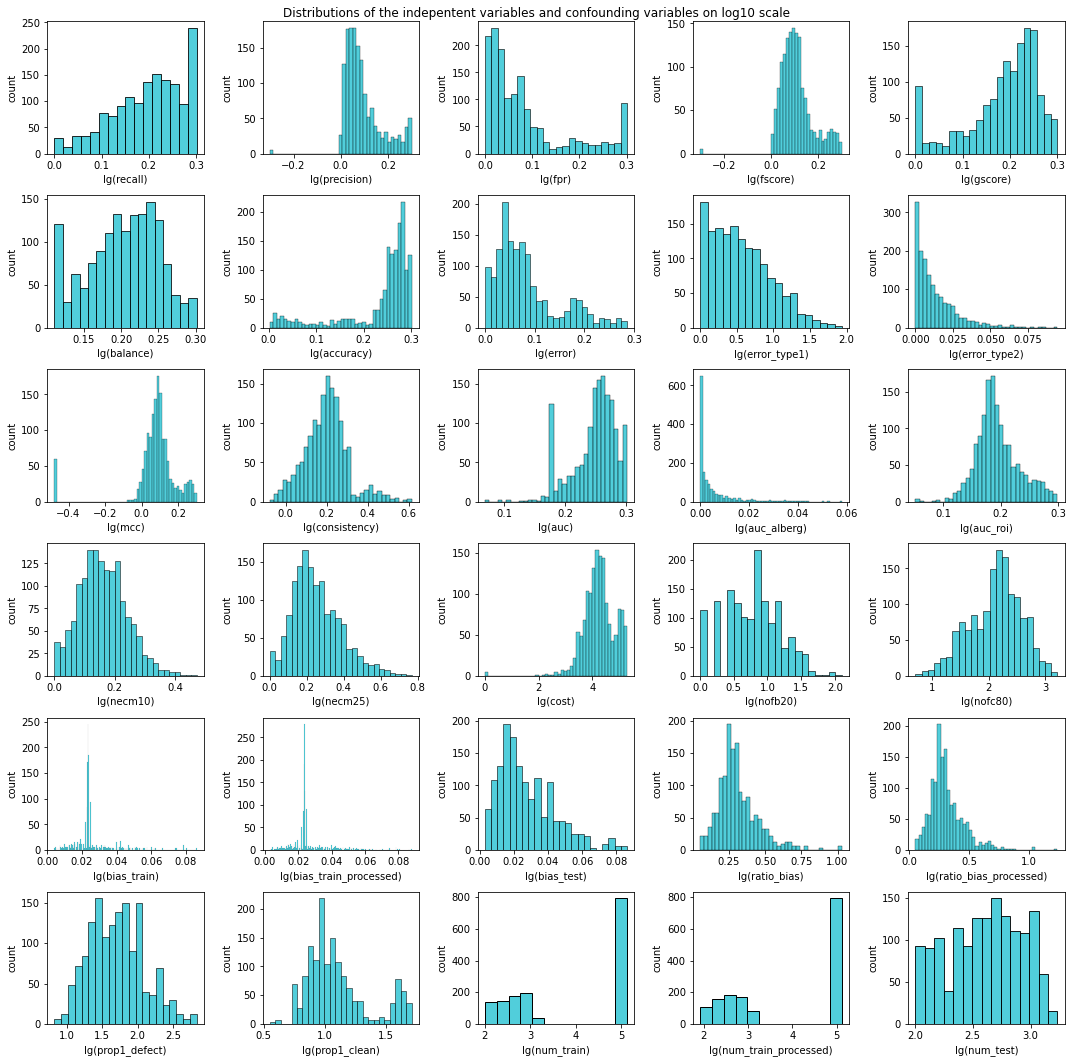

In [37]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))

feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(df_real, x=df_real.columns[feature_index], ax=col)
        col.set_ylabel("count")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "dist_independent_and_confounding.pdf"), bbox_inches='tight')

fig.suptitle("Distributions of the independent variables and confounding variables")
plt.tight_layout()
plt.show()

print("\n")

fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.histplot(x=np.sign(df_real.iloc[:,feature_index])*np.log10(np.abs(df_real.iloc[:,feature_index])+1), ax=col, color="tab:cyan")
        col.set_xlabel(f"lg({df_real.columns[feature_index]})")
        col.set_ylabel("count")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "dist_log_independent_and_confounding.pdf"), bbox_inches='tight')

fig.suptitle("Distributions of the indepentent variables and confounding variables on log10 scale")
plt.tight_layout()
plt.show()

Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns 141 instances.
Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns 585 instances.


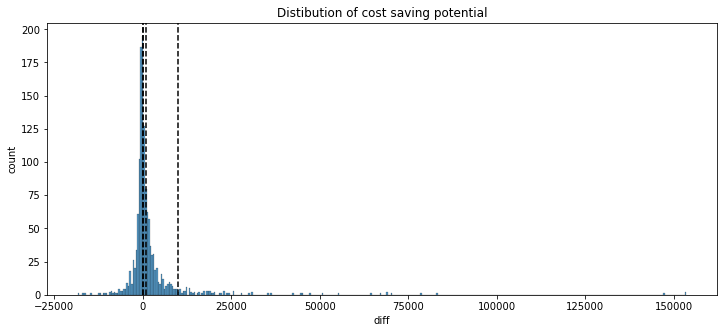

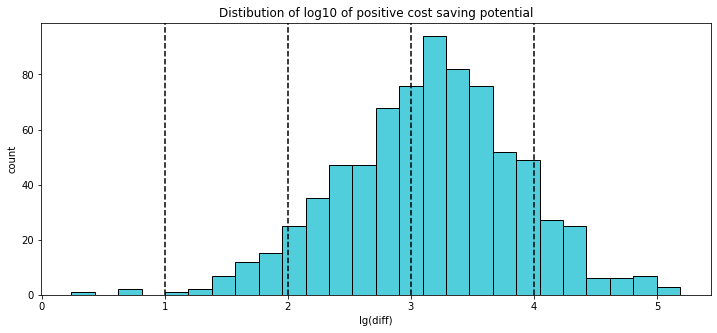

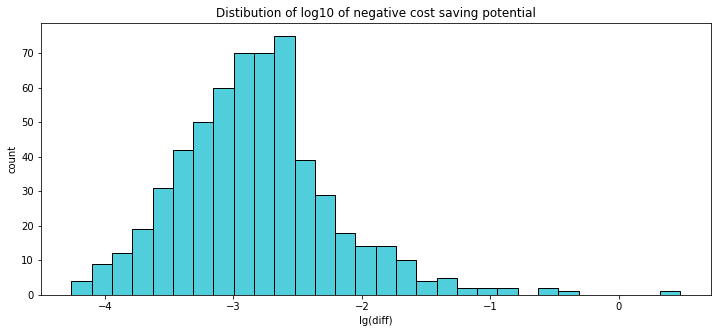

In [38]:
regular_diff = df_real.loc[~(df_real['diff'].isnull()) & ~(np.isinf(df_real["diff"])), 'diff']
pos_diff = regular_diff.loc[regular_diff > 0]
neg_diff = regular_diff.loc[regular_diff <= 0]
log_pos_diff = np.log10(pos_diff)
log_neg_diff = np.sign(regular_diff)*np.log10(abs(neg_diff))

log_diff = np.sign(regular_diff)*np.log10(np.abs(regular_diff))

print(f"Note: Unregular 'diff' values (NaN, -inf, +inf) are not included in the plots. This concerns {df_real.shape[0]-regular_diff.shape[0]} instances.")
print(f"Note: Additionally the regular negative 'diff' values (<=0) are not included in the logarithmic plot. This concerns {neg_diff.shape[0]} instances.")


plt.figure(figsize=(12,5))
sns.histplot(data=regular_diff)
plt.ylabel("count")
plt.axvline(10, color="black", linestyle="--")
plt.axvline(100, color="black", linestyle="--")
plt.axvline(1000, color="black", linestyle="--")
plt.axvline(10000, color="black", linestyle="--")

plt.savefig(os.path.join(GENERALIZATION_DIR, "dist_diff.pdf"), bbox_inches='tight')

plt.title("Distibution of cost saving potential")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(data=log_pos_diff, color="tab:cyan")
plt.ylabel("count")
plt.axvline(1, color="black", linestyle="--")
plt.axvline(2, color="black", linestyle="--")
plt.axvline(3, color="black", linestyle="--")
plt.axvline(4, color="black", linestyle="--")
plt.xlabel("lg(diff)")

plt.savefig(os.path.join(GENERALIZATION_DIR, "dist_pos_log_diff.pdf"), bbox_inches='tight')

plt.title("Distibution of log10 of positive cost saving potential")
plt.show()


plt.figure(figsize=(12,5))
sns.histplot(data=log_neg_diff, color="tab:cyan")
plt.ylabel("count")
plt.xlabel("lg(diff)")

plt.savefig(os.path.join(GENERALIZATION_DIR, "dist_neg_log_diff.pdf"), bbox_inches='tight')

plt.title("Distibution of log10 of negative cost saving potential")
plt.show()

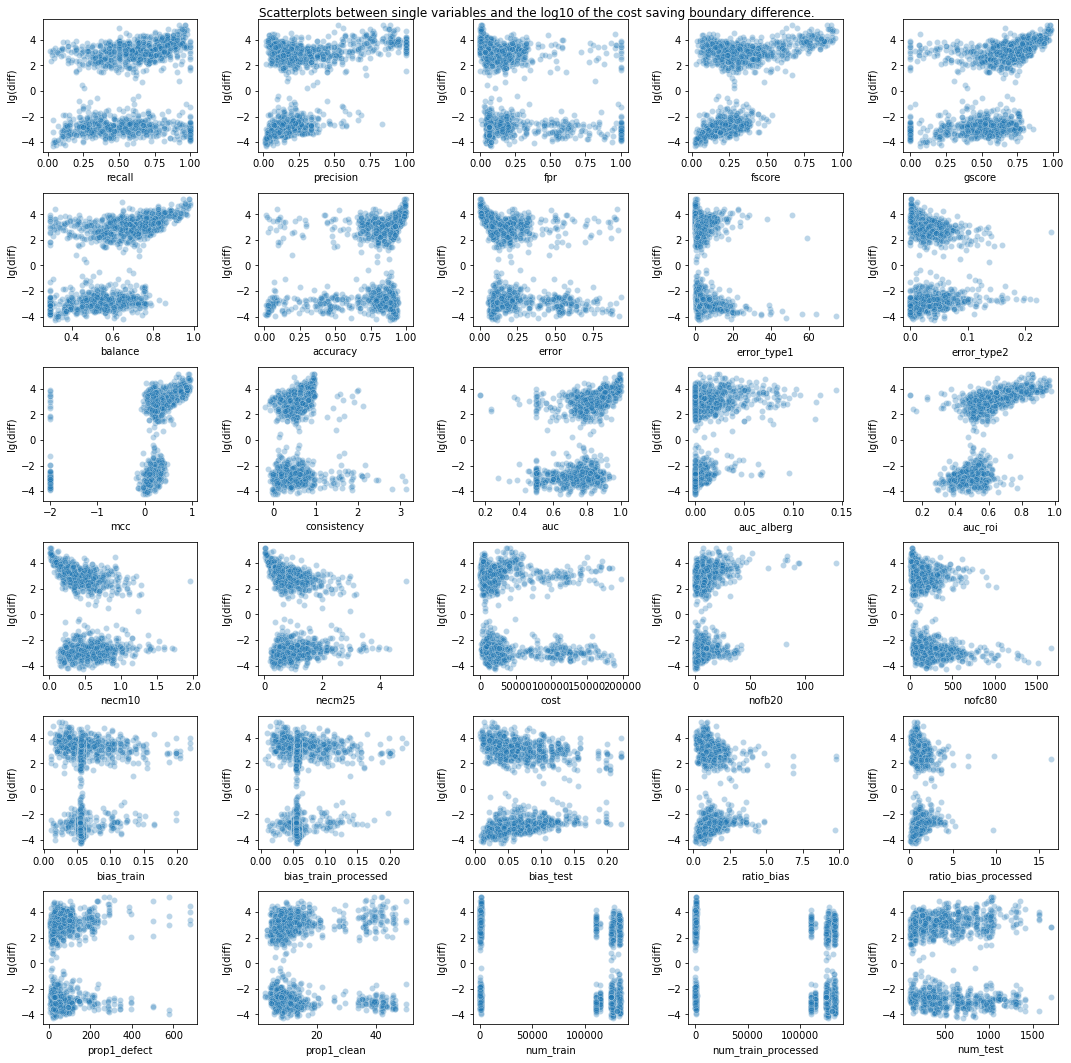

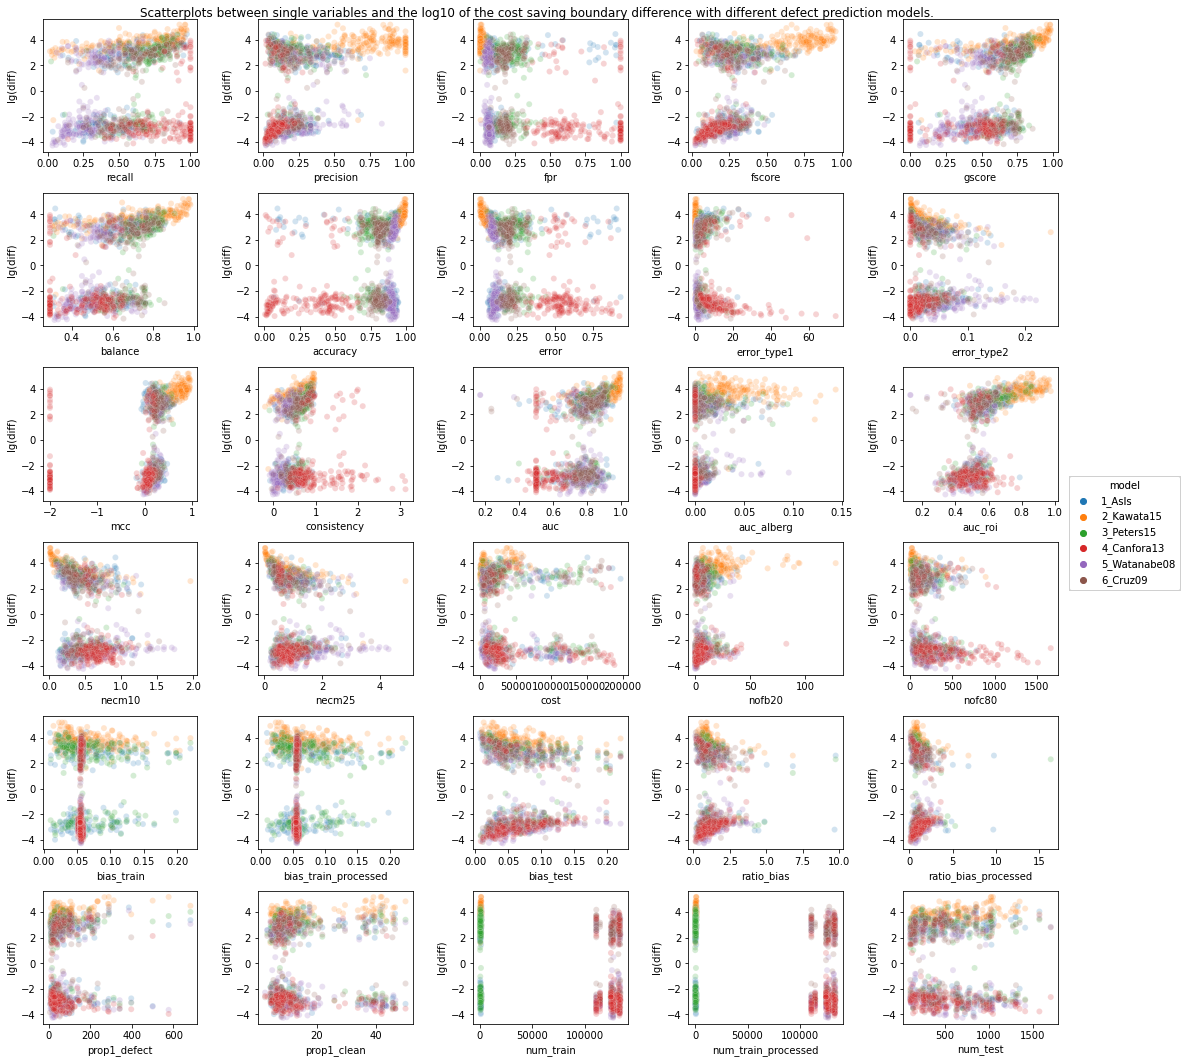

In [39]:
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        sns.scatterplot(x=df_real.iloc[:,feature_index], y=log_diff, ax=col, alpha=0.3)
        col.set_ylabel("lg(diff)")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "scatter_log_diff.pdf"), bbox_inches='tight')

fig.suptitle("Scatterplots between single variables and the log10 of the cost saving boundary difference.")
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
for row in axes:
    for col in row:
        col = sns.scatterplot(x=df_real.iloc[:,feature_index], y=log_diff, ax=col, alpha=0.2, hue=df_real.iloc[:,0], 
                              hue_order=['1_AsIs','2_Kawata15','3_Peters15','4_Canfora13','5_Watanabe08','6_Cruz09'])
        col.set_ylabel("lg(diff)")
        col.get_legend().remove()
        handles, labels = col.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1,0.55), title="model")
        feature_index += 1
        
plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "scatter_log_diff_grouped.pdf"), bbox_inches='tight')

fig.suptitle("Scatterplots between single variables and the log10 of the cost saving boundary difference with different defect prediction models.")
plt.tight_layout()
plt.show()

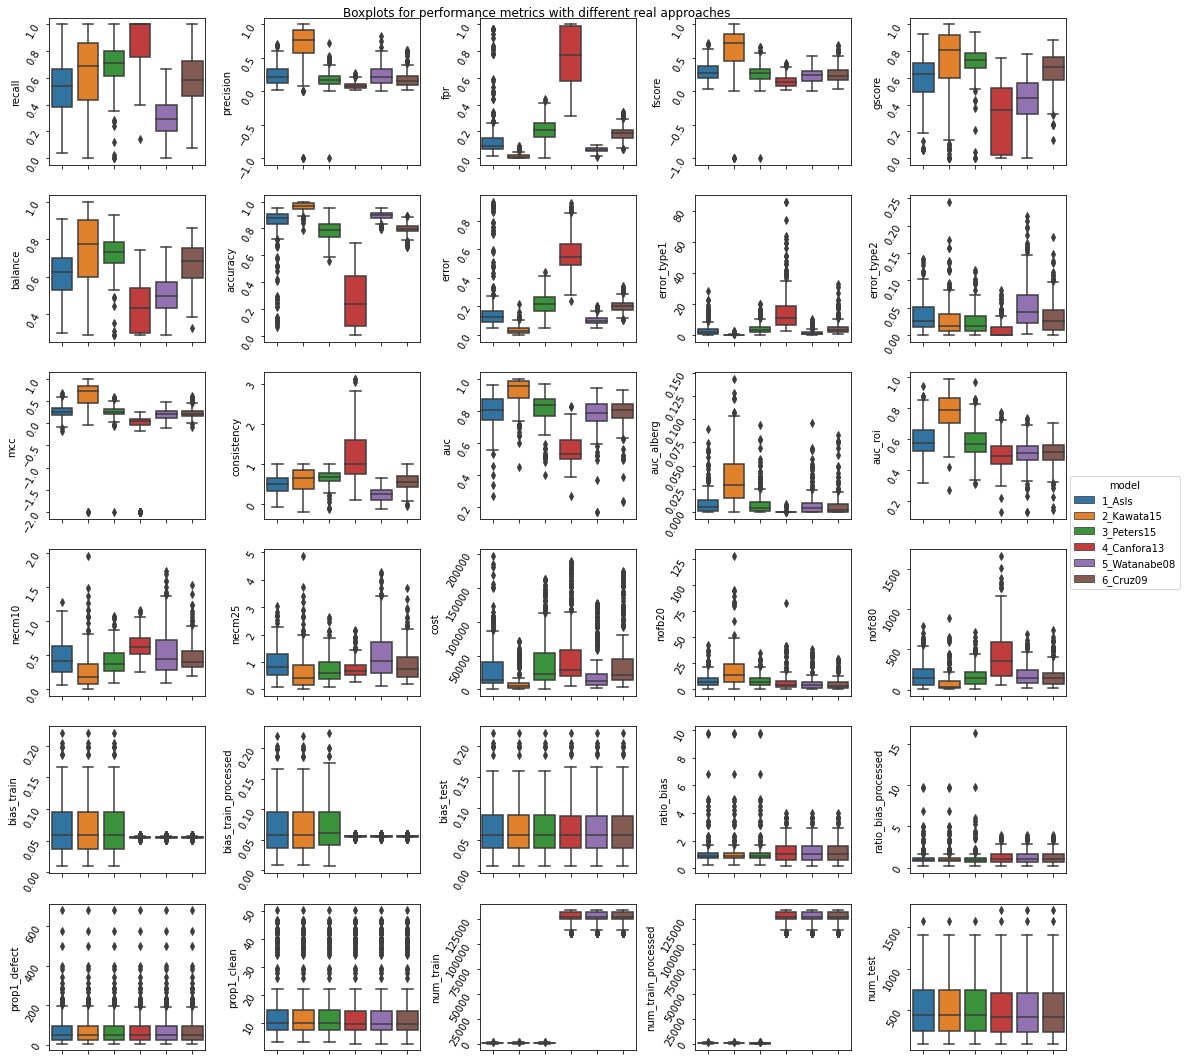

In [40]:
other_approach_list = ['1_AsIs','2_Kawata15','3_Peters15','4_Canfora13','5_Watanabe08','6_Cruz09']
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
first_flag = True
for row in axes:
    for col in row:
        if first_flag:
            sns.boxplot(x=df_real.iloc[:,0], y=df_real.iloc[:,6], hue=df_real.iloc[:,0], ax=col,
               order=other_approach_list, hue_order=other_approach_list)
            col.get_legend().remove()
            handles, labels = col.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1,0.55), title="model")
            col.clear()
            first_flag = False
        #col = sns.boxplot(x=df_real.iloc[:,feature_index], y=log_diff, ax=col, hue=df_real.iloc[:,0])
        sns.boxplot(x=df_real.iloc[:,0], y=df_real.iloc[:,feature_index], ax=col, order=other_approach_list)
        col.set(xticklabels=[])  # remove the tick labels
        col.set(xlabel=None)
        col.tick_params(labelrotation=60)  
        feature_index += 1
     
plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "boxplot_real_approaches.pdf"), bbox_inches='tight')

fig.suptitle("Boxplots for performance metrics with different real approaches")
plt.tight_layout()
plt.show()

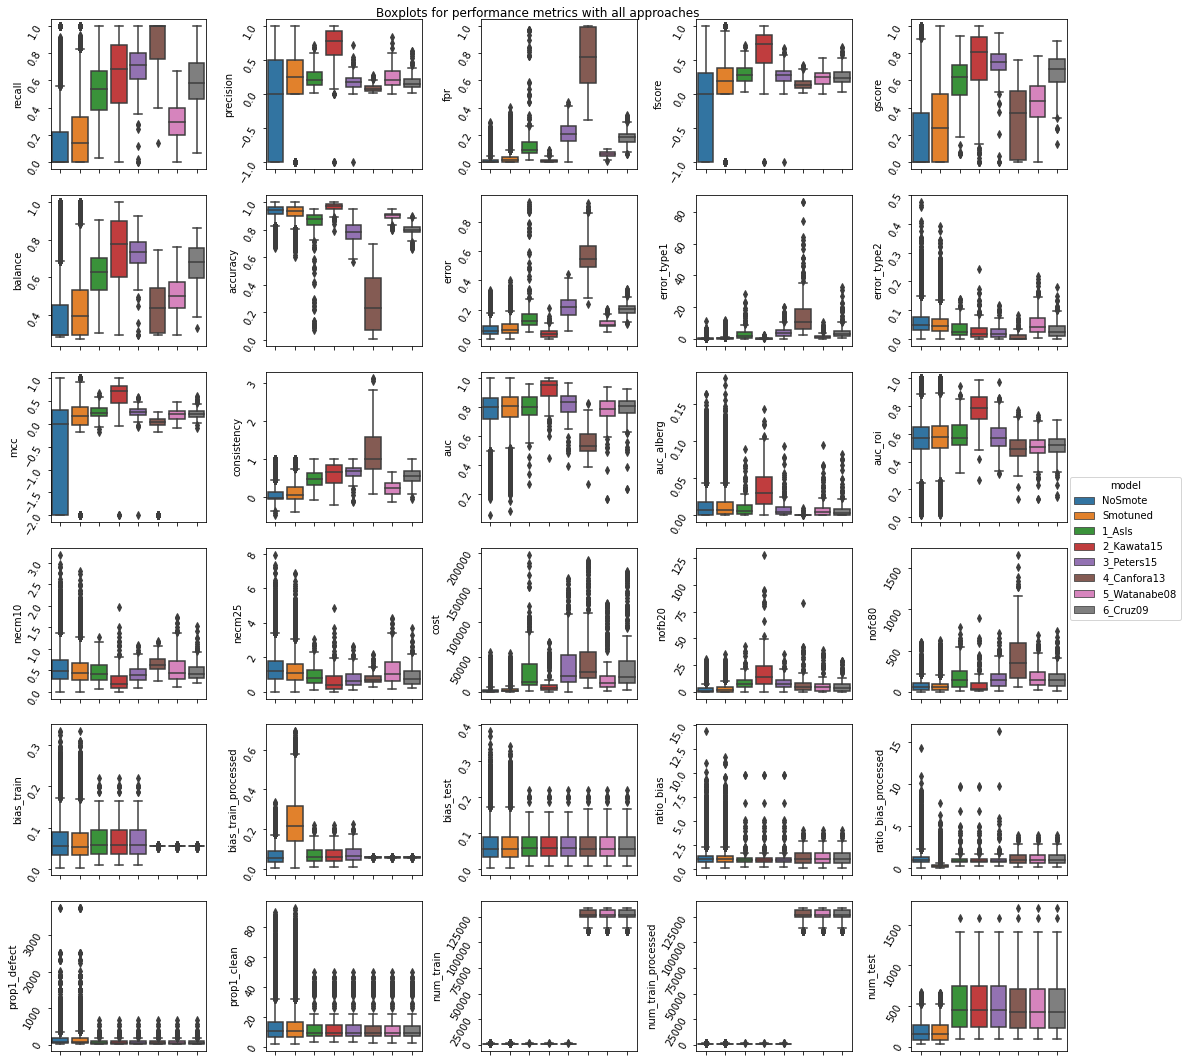

In [41]:
full_df = df.append(df_real)
full_approach_list = ['NoSmote','Smotuned','1_AsIs','2_Kawata15','3_Peters15','4_Canfora13','5_Watanabe08','6_Cruz09']
fig, axes = plt.subplots(6, 5, figsize=(15,15))
feature_index = FIRST_NUM_FEATURE_IDX
first_flag = True
for row in axes:
    for col in row:
        if first_flag:
            sns.boxplot(x=full_df.iloc[:,0], y=full_df.iloc[:,6], hue=full_df.iloc[:,0], ax=col,
               order=full_approach_list, hue_order=full_approach_list)
            col.get_legend().remove()
            handles, labels = col.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1,0.55), title="model")
            col.clear()
            first_flag = False
        #col = sns.boxplot(x=full_df.iloc[:,feature_index], y=log_diff, ax=col, hue=full_df.iloc[:,0])
        sns.boxplot(x=full_df.iloc[:,0], y=full_df.iloc[:,feature_index], ax=col, order=full_approach_list)
        col.set(xticklabels=[])  # remove the tick labels
        col.set(xlabel=None)
        col.tick_params(labelrotation=60)  
        feature_index += 1
     
plt.tight_layout()
fig.savefig(os.path.join(GENERALIZATION_DIR, "boxplot_all_approaches.pdf"), bbox_inches='tight')

fig.suptitle("Boxplots for performance metrics with all approaches")
plt.tight_layout()
plt.show()

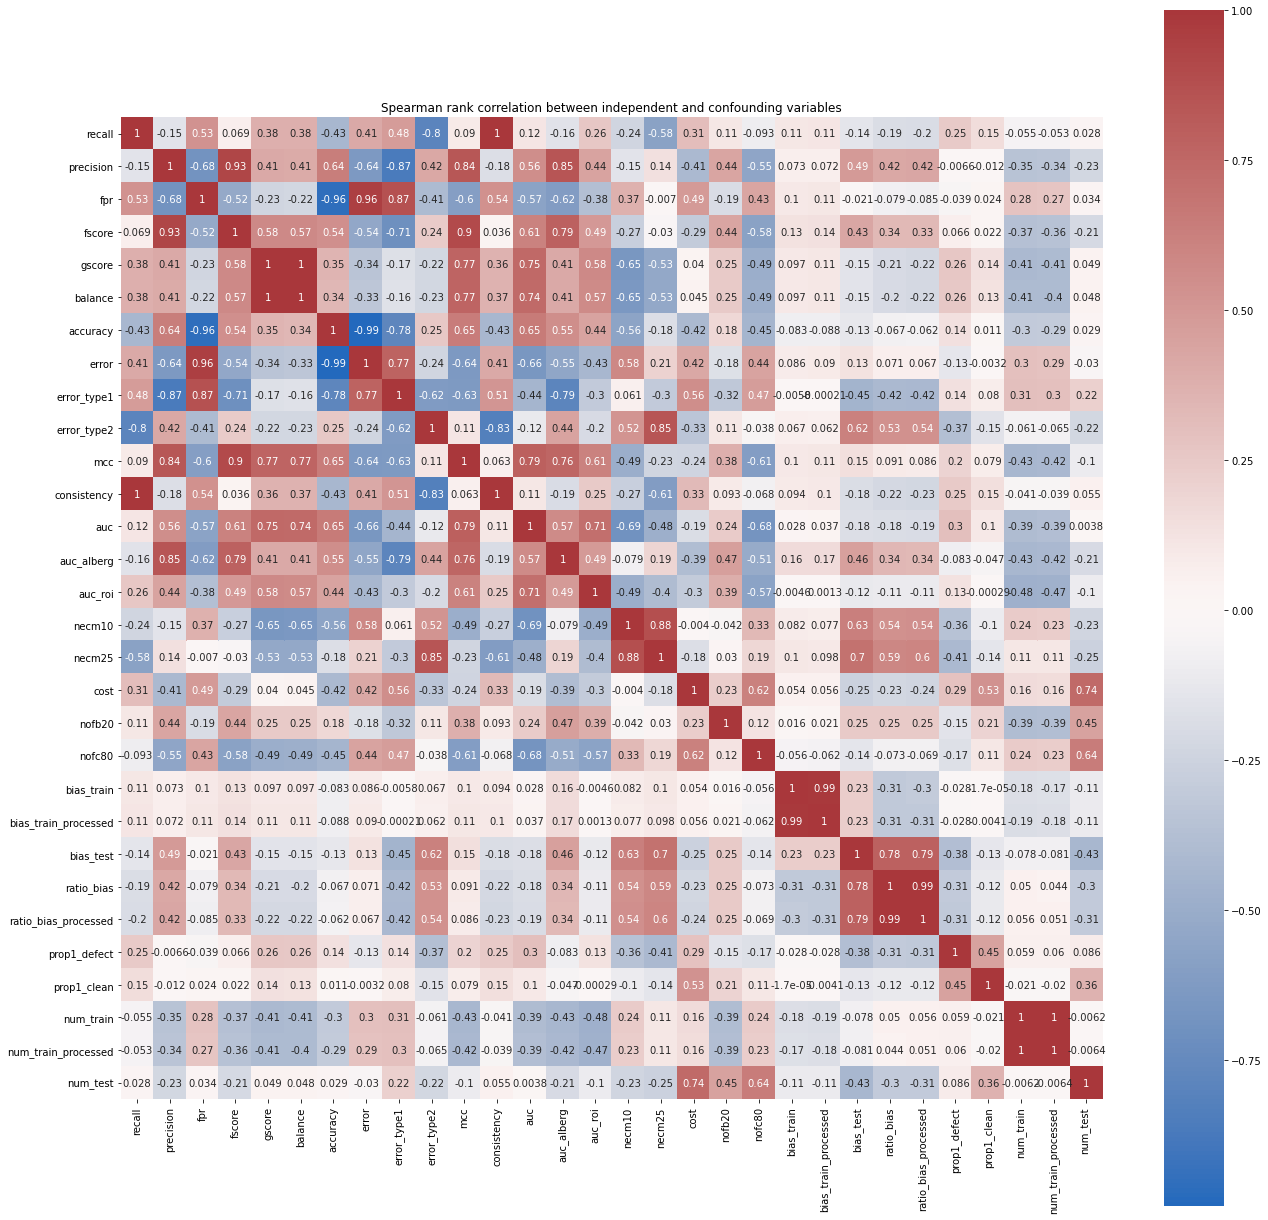

In [42]:
df_real_numeric = df_real.iloc[:,FIRST_NUM_FEATURE_IDX:FIRST_NUM_FEATURE_IDX+30]
overall_spearman_corr_map_real = spearmanr(a=df_real_numeric).correlation

plt.figure(figsize=(22,22))
ax = sns.heatmap(overall_spearman_corr_map_real, square=True, annot=True, xticklabels=df_real_numeric.columns, yticklabels=df_real_numeric.columns, cmap="vlag")

plt.savefig(os.path.join(GENERALIZATION_DIR, "corr_all.pdf"), bbox_inches='tight')

plt.title("Spearman rank correlation between independent and confounding variables")
plt.show()

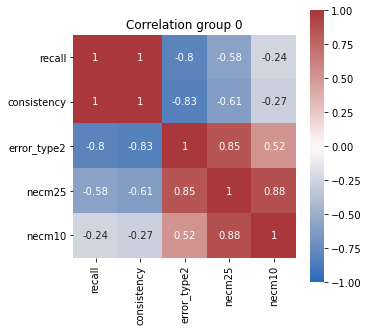

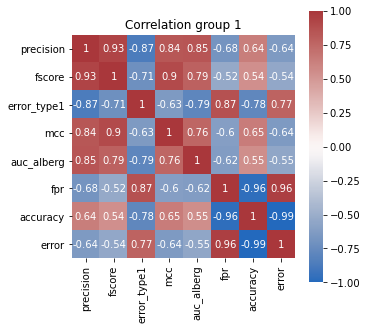

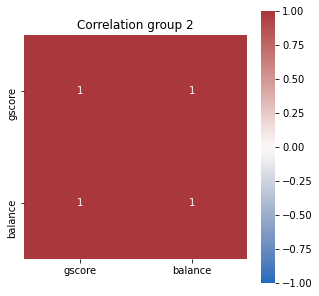

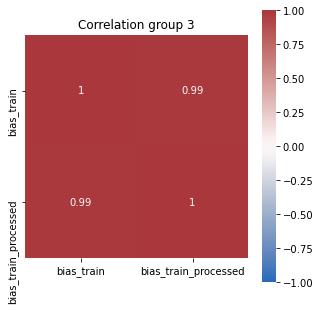

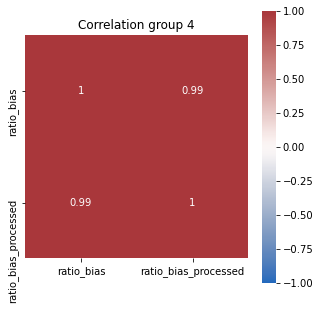

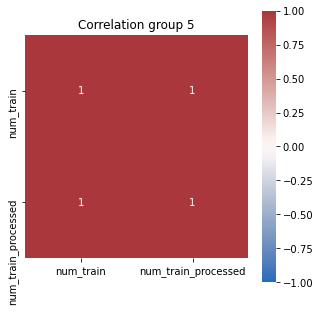

In [43]:
detect_correlation_groups(overall_spearman_corr_map_real, df_real_numeric, GENERALIZATION_DIR, CORRELATION_THRESHOLD)

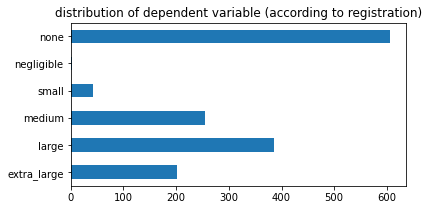

Original potential classes:
 none           605
negligible       3
small           42
medium         254
large          385
extra_large    202
Name: potential, dtype: int64 




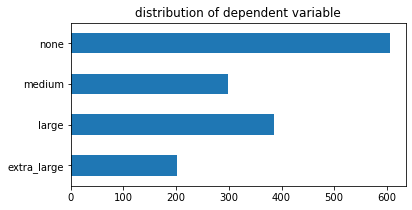

Condensed potential classes:
 none           605
medium         299
large          385
extra_large    202
Name: potential, dtype: int64 




In [44]:
original_classes = ['none','negligible','small','medium','large','extra_large']
plt.figure(figsize=(6,3))
df_real['potential'].value_counts()[original_classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, f"dist_dependent_original.pdf"), bbox_inches='tight')
plt.title("distribution of dependent variable (according to registration)")
plt.show()
print(f"Original potential classes:\n",df_real['potential'].value_counts()[original_classes], "\n\n")

# include 'negligible' and 'small' into 'medium'
df_real.loc[df_real['potential'] == 'negligible', 'potential'] = "medium"
df_real.loc[df_real['potential'] == 'small', 'potential'] = "medium"

classes = ['none','medium','large','extra_large']
plt.figure(figsize=(6,3))
df_real['potential'].value_counts()[classes].plot(kind='barh')
plt.gca().invert_yaxis()
plt.savefig(os.path.join(FIGURE_PATH, f"dist_dependent_updated.pdf"), bbox_inches='tight')
plt.title("distribution of dependent variable")
plt.show()
print(f"Condensed potential classes:\n",df_real['potential'].value_counts()[classes], "\n\n")

In [45]:
df_real_features = df_real.drop(['release', 'configuration', 'diff','potential'], axis = 1)
y_real = df_real['potential']
X_real = df_real_features

Xmax_real = X_real.max()
Xmin_real = X_real.min()
X_real = (X_real - Xmin_real)/(Xmax_real - Xmin_real)

name             GeneralLogisticRegression
training t.                              0
prediction t.                            0
recall                            0.271783
precision                         0.213546
accuracy                          0.300469
F1 measure                        0.160077
MCC                               0.082246
dtype: object


C:\Users\steffen\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


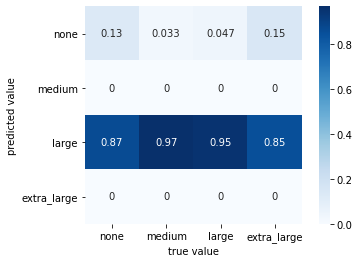

                              none    medium     large  extra_large
correctly_predicted       0.133884  0.000000  0.953247     0.000000
moderate_overprediction   0.000000  0.966555  0.000000          NaN
overall_overprediction    0.866116  0.966555  0.000000          NaN
moderate_underprediction       NaN  0.033445  0.000000     0.851485
overall_underprediction        NaN  0.033445  0.046753     1.000000


In [46]:
y_real_model = model_lr.predict(X_real)
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralLogisticRegression", df=metrics_df, save_dir=GENERALIZATION_DIR), ignore_index=True)

name             GeneralDecisionTree
training t.                        0
prediction t.                      0
recall                      0.307622
precision                   0.625244
accuracy                    0.274983
F1 measure                  0.268571
MCC                          0.05929
dtype: object


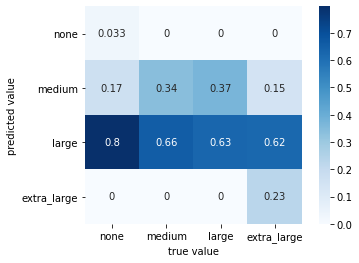

                              none    medium     large  extra_large
correctly_predicted       0.033058  0.341137  0.628571     0.227723
moderate_overprediction   0.170248  0.658863  0.000000          NaN
overall_overprediction    0.966942  0.658863  0.000000          NaN
moderate_underprediction       NaN  0.000000  0.371429     0.623762
overall_underprediction        NaN  0.000000  0.371429     0.772277


In [47]:
y_real_model = model_dt.predict(X_real)
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralDecisionTree", df=metrics_df, save_dir=GENERALIZATION_DIR), ignore_index=True)

name             GeneralRandomForest
training t.                        0
prediction t.                      0
recall                      0.380336
precision                    0.56916
accuracy                    0.352783
F1 measure                  0.343015
MCC                         0.176272
dtype: object


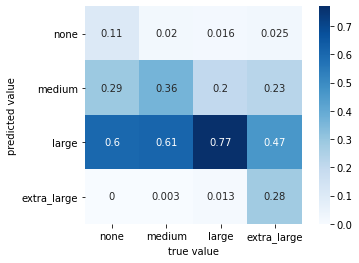

                              none    medium     large  extra_large
correctly_predicted       0.105785  0.364548  0.768831     0.282178
moderate_overprediction   0.292562  0.612040  0.012987          NaN
overall_overprediction    0.894215  0.615385  0.012987          NaN
moderate_underprediction       NaN  0.020067  0.202597     0.465347
overall_underprediction        NaN  0.020067  0.218182     0.717822


In [48]:
y_real_model = model_rf.predict(X_real)
metrics_df = metrics_df.append(performance_eval(y_real_model, y_real, classes, name="GeneralRandomForest", df=metrics_df, save_dir=GENERALIZATION_DIR), ignore_index=True)

In [49]:
metrics_df

name  training t.  prediction t.    recall  \
0          LogisticRegression     0.609881       0.008065  0.491113   
1                DecisionTree     0.269070       0.008126  0.859244   
2           PlainRandomForest     0.870760       0.062491  0.905051   
3           TunedRandomForest     1.447266       0.041287  0.904627   
4   ConfirmLogisticRegression     0.158337       0.000000  0.427449   
5         ConfirmDecisionTree     0.044272       0.002082  0.825758   
6    ConfirmPlainRandomForest     0.418048       0.036211  0.825887   
7    ConfirmTunedRandomForest     0.389103       0.053427  0.830810   
8   GeneralLogisticRegression     0.000000       0.000000  0.271783   
9         GeneralDecisionTree     0.000000       0.000000  0.307622   
10        GeneralRandomForest     0.000000       0.000000  0.380336   

    precision  accuracy  F1 measure       MCC  
0    0.402487  0.797484    0.439810  0.698836  
1    0.900657  0.922767    0.876751  0.879388  
2    0.920396  0.946792    0.912461  0.916633  
3    0.921971  0.947736    0.912958  0.918107  
4    0.347183  0.704591    0.382368  0.525481  
5    0.885052  0.909937    0.850525  0.859226  
6    0.843133  0.896792    0.834119  0.838205  
7    0.894919  0.915472    0.858107  0.867378  
8    0.213546  0.300469    0.160077  0.082246  
9    0.625244  0.274983    0.268571  0.059290  
10   0.569160  0.352783    0.343015  0.176272